In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import yaml
import random

from tqdm import tqdm
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix

from pyhealth.datasets import SampleEHRDataset, get_dataloader
from pyhealth.models import Transformer,RNN
from pyhealth.trainer import Trainer
from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.fairness import fairness_metrics_fn

# Creating the Dataset

This code works with the public MIMIC-III ICU stay database. Before using the code, please apply, complete training, and download the requisite files from <https://physionet.org>. The required files are:
* 'PATIENTS.csv'
* 'ADMISSIONS.csv'
* 'DIAGNOSES_ICD.csv'
* 'PROCEDURES_ICD.csv'
* 'PRESCRIPTIONS.csv'
* 'CHARTEVENTS.csv'

## Patient Event Generation
Next, to create the patient events you need to perform the mimic3-benchmarks preprocessing according the the repository found at <https://github.com/YerevaNN/mimic3-benchmarks>. That repository has comprehensive documentation, and it will create a series of .csv files containing lab time-series information for each ICU stay. You just need to get through the `extract_episodes_from_subjects` step.

From there,  edit the `mimic_dir` and `timeseries_dir` variables in the notebook. Running the cell will generate all of the base data files for the experiments.

Next, we need to discretize the continuous variables to feed them into the generator. To do so, create a `discretized_data/` directory and run the cell under 'discretize'

At this point, the discretized data and corresponding artifacts will be available, and your dataset will be fully processed.

In [2]:
mimic_dir = "D:\\Phd\\Prelim\\mimic3\\"
timeseries_dir = "data\\mimic3-benchmarks\\root\\"
valid_subjects = os.listdir(timeseries_dir)
patientsFile = mimic_dir + "PATIENTS.csv"
admissionFile = mimic_dir + "ADMISSIONS.csv"
diagnosisFile = mimic_dir + "DIAGNOSES_ICD.csv"
procedureFile = mimic_dir + "PROCEDURES_ICD.csv"
medicationFile = mimic_dir + "PRESCRIPTIONS.csv"

channel_to_id = pickle.load(open("data\\channel_to_id.pkl", "rb"))
is_categorical_channel = pickle.load(open("data\\is_categorical_channel.pkl", "rb"))
possible_values = pickle.load(open("data\\possible_values.pkl", "rb"))
begin_pos = pickle.load(open("data\\begin_pos.pkl", "rb"))
end_pos = pickle.load(open("data\\end_pos.pkl", "rb"))

print("Loading CSVs Into Dataframes")
patientsDf = pd.read_csv(patientsFile, dtype=str).set_index("SUBJECT_ID")
patientsDf['DOB'] = pd.to_datetime(patientsDf['DOB'])
patientsDf['DOD'] = pd.to_datetime(patientsDf['DOD'])
patientsDf['DOD_HOSP'] = pd.to_datetime(patientsDf['DOD_HOSP'])

gender_mapping = {gender: index for index, gender in enumerate({'M','F'})}
patientsDf['GENDER_MAP'] = patientsDf['GENDER'].map(gender_mapping)

admissionDf = pd.read_csv(admissionFile, dtype=str)
admissionDf['ADMITTIME'] = pd.to_datetime(admissionDf['ADMITTIME'])
admissionDf['DISCHTIME'] = pd.to_datetime(admissionDf['DISCHTIME'])
admissionDf['DEATHTIME'] = pd.to_datetime(admissionDf['DEATHTIME'])
def map_ethnicity(ethnicity):
    if 'WHITE' in ethnicity:
        return 0
    elif 'BLACK' in ethnicity:
        return 1
    elif 'HISPANIC' in ethnicity:
        return 2
    elif 'ASIAN' in ethnicity:
        return 3
    else:
        return 4

admissionDf["ETHNICITY_MAP"] = admissionDf['ETHNICITY'].apply(map_ethnicity)
insurance_mapping = {
    'Private': 0,
    'Medicare': 1,
    'Medicaid': 2,
    'Self Pay': 3,
    'Government': 4
}
admissionDf["INSURANCE_MAP"] = admissionDf['INSURANCE'].map(insurance_mapping)
admissionDf = admissionDf.sort_values('ADMITTIME')
admissionDf = admissionDf.reset_index(drop=True)

diagnosisDf = pd.read_csv(diagnosisFile, dtype=str).set_index("HADM_ID")
diagnosisDf = diagnosisDf[diagnosisDf['ICD9_CODE'].notnull()]
diagnosisDf = diagnosisDf[diagnosisDf['ICD9_CODE'].str.startswith("428")]
diagnosisDf = diagnosisDf[['ICD9_CODE']]

procedureDf = pd.read_csv(procedureFile, dtype=str).set_index("HADM_ID")
procedureDf = procedureDf[procedureDf['ICD9_CODE'].notnull()]
procedureDf = procedureDf[['ICD9_CODE']]

medicationDf = pd.read_csv(medicationFile, dtype=str).set_index("HADM_ID")
medicationDf = medicationDf[medicationDf['NDC'].notnull()]
medicationDf = medicationDf[medicationDf['NDC'] != 0]
medicationDf = medicationDf[['NDC', 'DRUG']]
medicationDf['NDC'] = medicationDf['NDC'].astype(np.int64).astype(str)
medicationDf['NDC'] = [('0' * (11 - len(c))) + c for c in medicationDf['NDC']]
medicationDf['NDC'] = [c[0:5] + '-' + c[5:9] + '-' + c[10:12] for c in medicationDf['NDC']]
print("DONE LAODING")

Loading CSVs Into Dataframes
DONE LAODING


# Exploratory Data Analysis

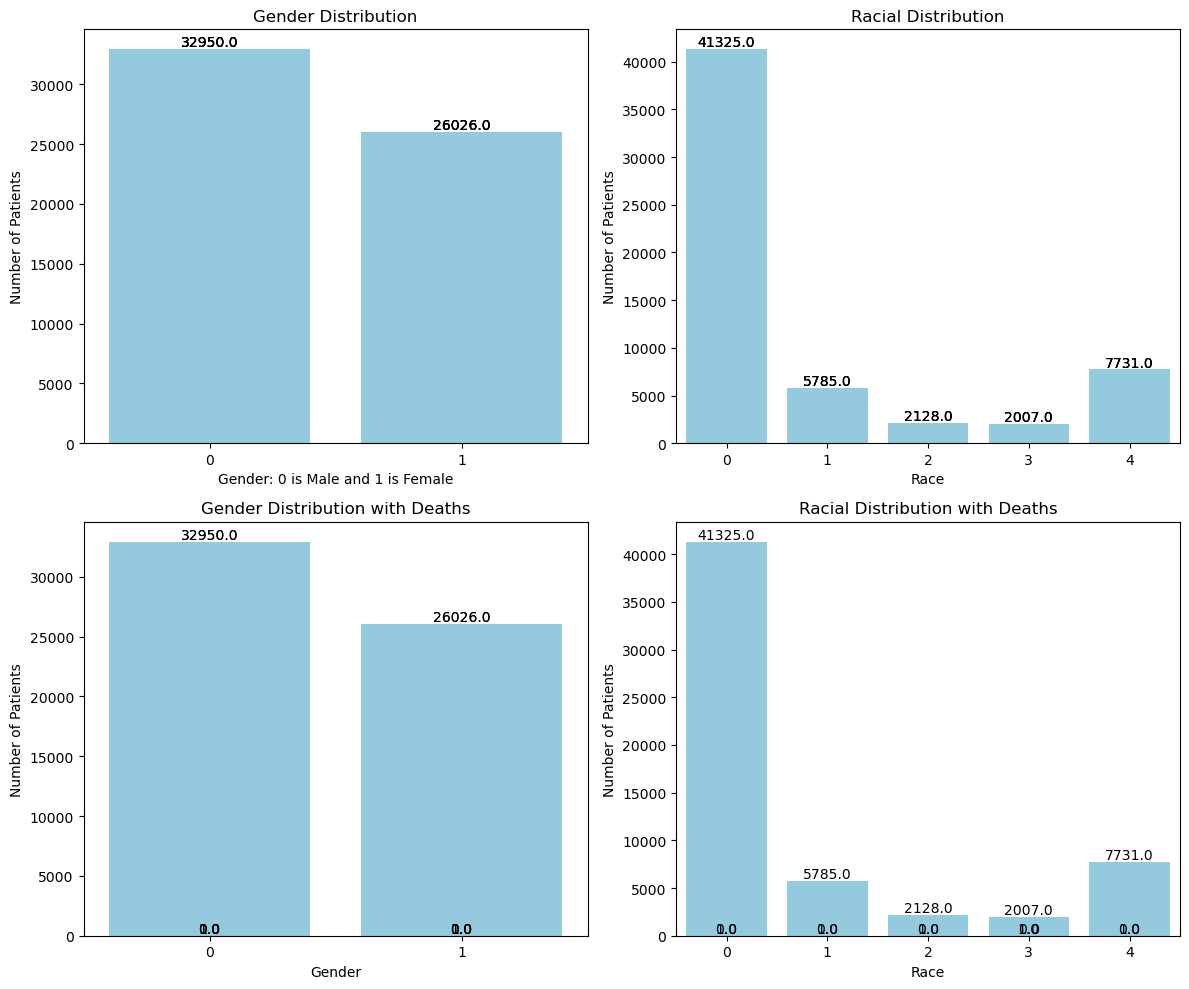

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming patientDf and admissionDf are your dataframes
merged_data = pd.merge(admissionDf, patientsDf, on='SUBJECT_ID')

# Gender distribution
gender_counts = merged_data['GENDER_MAP'].value_counts()
gender_deaths = merged_data.groupby(['GENDER_MAP', 'HOSPITAL_EXPIRE_FLAG']).size().unstack(fill_value=0)

# Racial distribution
race_counts = merged_data['ETHNICITY_MAP'].value_counts()
race_deaths = merged_data.groupby(['ETHNICITY_MAP', 'HOSPITAL_EXPIRE_FLAG']).size().unstack(fill_value=0)

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gender distribution
sns.barplot(x=gender_counts.index, y=gender_counts.values, color='skyblue', ax=axs[0, 0])
axs[0, 0].set_title('Gender Distribution')
axs[0, 0].set_xlabel('Gender: 0 is Male and 1 is Female')
axs[0, 0].set_ylabel('Number of Patients')
for ax in axs.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Racial distribution
sns.barplot(x=race_counts.index, y=race_counts.values, color='skyblue', ax=axs[0, 1])
axs[0, 1].set_title('Racial Distribution')
axs[0, 1].set_xlabel('Race')
axs[0, 1].set_ylabel('Number of Patients')
for ax in axs.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Number of patients of each gender (stacked)
sns.barplot(data=gender_counts.reset_index(), x='index', y='GENDER_MAP', color='skyblue', ax=axs[1, 0])
sns.barplot(data=gender_deaths.reset_index(), x='GENDER_MAP', y=1, color='red', ax=axs[1, 0])
sns.barplot(data=gender_deaths.reset_index(), x='GENDER_MAP', y=0, color='green', ax=axs[1, 0])
axs[1, 0].set_title('Gender Distribution with Deaths')
axs[1, 0].set_xlabel('Gender')
axs[1, 0].set_ylabel('Number of Patients')
for ax in axs.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Number of patients of each ethnicity (stacked)
sns.barplot(data=race_counts.reset_index(), x='index', y='ETHNICITY_MAP', color='skyblue', ax=axs[1, 1])
sns.barplot(data=race_deaths.reset_index(), x='ETHNICITY_MAP', y=1, color='red', ax=axs[1, 1])
sns.barplot(data=race_deaths.reset_index(), x='ETHNICITY_MAP', y=0, color='green', ax=axs[1, 1])
axs[1, 1].set_title('Racial Distribution with Deaths')
axs[1, 1].set_xlabel('Race')
axs[1, 1].set_ylabel('Number of Patients')
for ax in axs.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')


plt.tight_layout()
plt.show()

In [ ]:
#Smaller dataset
print(len(admissionDf))
# Randomly sample 10,000 rows
admissionDf = admissionDf.sample(n=1000, random_state=42)  # You can adjust the random_state for reproducibility

print(len(admissionDf))

In [ ]:
print("Building Dataset")
data = {}
for row in tqdm(admissionDf.itertuples(), total=len(admissionDf)):
    hadm_id = row.HADM_ID
    subject_id = row.SUBJECT_ID
    admit_time = row.ADMITTIME
    ethnicity = row.ETHNICITY_MAP
    insurance = row.INSURANCE_MAP

    if subject_id not in patientsDf.index:
        continue
    visit_count = (0 if subject_id not in data else len(data[subject_id]["visits"])) + 1

    tsDf = (
        pd.read_csv(f"{timeseries_dir}{subject_id}/episode{visit_count}_timeseries.csv")
        if os.path.exists(
            f"{timeseries_dir}{subject_id}/episode{visit_count}_timeseries.csv"
        )
        else None
    )

    patientRow = patientsDf.loc[[subject_id]].iloc[0]
    age = (admit_time.to_pydatetime() - patientRow["DOB"].to_pydatetime()).days / 365
    if age > 120:
        continue

    # Extracting the Diagnoses
    if hadm_id in diagnosisDf.index:
        diagnoses = list(set(diagnosisDf.loc[[hadm_id]]["ICD9_CODE"]))
    else:
        diagnoses = []

    # Extracting the Procedures
    if hadm_id in procedureDf.index:
        procedures = list(set(procedureDf.loc[[hadm_id]]["ICD9_CODE"]))
    else:
        procedures = []

    # Extracting the Medications
    if hadm_id in medicationDf.index:
        medications = list(set(medicationDf.loc[[hadm_id]]["NDC"]))
    else:
        medications = []

    # Extract the lab timeseries
    labs = []
    prevTime = 0
    currTime = int(tsDf.iloc[0]["Hours"]) if tsDf is not None else 0
    currMask = []
    currValues = []
    if tsDf is not None:
        for i, row in tsDf.iterrows():
            rowTime = int(row["Hours"])

            if rowTime != currTime:
                labs.append((currMask, currValues, [currTime - prevTime]))
                prevTime = currTime
                currTime = rowTime
                currMask = []
                currValues = []

            for col, value in row.items():
                if value != value or col == "Hours":
                    continue

                if is_categorical_channel[col]:
                    if col == "Glascow coma scale total":
                        value = str(int(value))
                    elif col == "Capillary refill rate":
                        value = str(value)

                    if begin_pos[channel_to_id[col]] in currMask:
                        currValues[
                            currMask.index(
                                begin_pos[channel_to_id[col]]
                                + possible_values[col].index(value)
                            )
                        ] = 1
                    else:
                        for j in range(
                            begin_pos[channel_to_id[col]], end_pos[channel_to_id[col]]
                        ):
                            currMask.append(j)
                            currValues.append(
                                1
                                if j - begin_pos[channel_to_id[col]]
                                == possible_values[col].index(value)
                                else 0
                            )
                else:
                    if begin_pos[channel_to_id[col]] in currMask:
                        currValues[
                            currMask.index(begin_pos[channel_to_id[col]])
                        ] = value
                    else:
                        currMask.append(begin_pos[channel_to_id[col]])
                        currValues.append(value)

        labs.append((currMask, currValues, [currTime - prevTime]))

        # Building the hospital admission data point
    if subject_id not in data:
        data[subject_id] = {
            "visits": [(diagnoses, procedures, medications, age, labs)],
            "gender": patientRow.GENDER_MAP,
            "ethnicity": ethnicity,
            "insurance": insurance,
            "isDead": patientRow.EXPIRE_FLAG,
        }
    else:
        data[subject_id]["visits"].append(
            (diagnoses, procedures, medications, age, labs)
        )
pickle.dump(data, open("./data/data_genDatasetContinuous.pkl", "wb"))

# Build the label mapping
print("Adding Labels")
with open("../hcup_ccs_2015_definitions_benchmark.yaml") as definitions_file:
    definitions = yaml.full_load(definitions_file)

code_to_group = {}
for group in definitions:
    if definitions[group]["use_in_benchmark"] == False:
        continue
    codes = definitions[group]["codes"]
    for code in codes:
        if code not in code_to_group:
            code_to_group[code] = group
        else:
            assert code_to_group[code] == group

id_to_group = sorted(
    [k for k in definitions.keys() if definitions[k]["use_in_benchmark"] == True]
)
group_to_id = dict((x, i) for (i, x) in enumerate(id_to_group))

for p in data:
    label = np.zeros(len(group_to_id))
    for v in data[p]["visits"]:
        for d in v[0]:
            d = str(d)
            if d not in code_to_group:
                continue

            label[group_to_id[code_to_group[d]]] = 1

    data[p]["labels"] = label
    data[p]["labels"] = np.append(data[p]["labels"], data[p]["insurance"])
    data[p]["labels"] = np.append(data[p]["labels"], data[p]["ethnicity"])
    data[p]["labels"] = np.append(data[p]["labels"], data[p]["gender"])
    data[p]["labels"] = np.append(data[p]["labels"], data[p]["isDead"])

# Convert diagnoses, procedures, and medications to text
print("Converting Codes to Text")
medMapping = {row["NDC"]: row["DRUG"] for _, row in medicationDf.iterrows()}
for p in data:
    new_visits = []
    for v in data[p]["visits"]:
        new_visit = []
        for c in v[0]:
            new_visit.append(c)
        for c in v[1]:
            new_visit.append(c)
        for c in v[2]:
            if c in medMapping:
                new_visit.append(medMapping[c])
            else:
                new_visit.append(c)

        new_visits.append((new_visit, [], [], [v[3]]))

        for lab_v in v[4]:
            new_visits.append(([], lab_v[0], lab_v[1], lab_v[2]))
    data[p]["visits"] = new_visits

# Convert diagnoses, procedures, and medications to indices

print("Converting Codes to Indices")
allCodes = list(set([c for p in data for v in data[p]["visits"] for c in v[0]]))
np.random.shuffle(allCodes)
code_to_index = {c: i for i, c in enumerate(allCodes)}
counter = 0
for p in data:
    new_visits = []
    for v in data[p]["visits"]:
        new_visit = []
        for c in v[0]:
            new_visit.append(code_to_index[c])

        new_visits.append((new_visit, v[1], v[2], v[3]))
    data[p]["visits"] = new_visits

index_to_code = {v: k for k, v in code_to_index.items()}
data = list(data.values())

MAX_TIME_STEPS = 150
data = [
    {"labels": data[i]["labels"], "visits": data[i]["visits"][: MAX_TIME_STEPS - 2]}
    for i in range(len(data))
]  # 2 for the start and label visits

In [ ]:
len(data)

In [ ]:
# Train-Val-Test Split
print("Splitting Datasets")
train_dataset, test_dataset = train_test_split(
    data, test_size=0.4, random_state=4, shuffle=True
) # train 60, val 10, test 30
train_dataset, val_dataset = train_test_split(
    train_dataset, test_size=0.1, random_state=4, shuffle=True
)

# Save Everything
print("Saving Everything")
print(len(index_to_code))
print(len(data[0]["labels"]))
pickle.dump(
    dict((i, x) for (x, i) in list(group_to_id.items())),
    open("./data/idToLabel.pkl", "wb"),
)
pickle.dump(index_to_code, open("./data/indexToCode.pkl", "wb"))
pickle.dump(data, open("./data/allData_1000.pkl", "wb"))
pickle.dump(train_dataset, open("./data/trainData.pkl", "wb"))
pickle.dump(val_dataset, open("./data/valData.pkl", "wb"))
pickle.dump(test_dataset, open("./data/testData.pkl", "wb"))

# Fairness Metrics for Real Dataset

In [13]:
import pickle
import random
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.fairness import fairness_metrics_fn
from pyhealth.models import RNN, Transformer
from pyhealth.trainer import Trainer
from pyhealth.datasets import SampleEHRDataset, get_dataloader, split_by_patient
from pyhealth.datasets.splitter import split_by_patient

allData_5000 = pickle.load(open("./data/allData_5000.pkl","rb"))
allData_1000 = allData_5000[0:1000]
# Train-Val-Test Split
print("Splitting Datasets")
train_ehr_data, test_ehr_data = train_test_split(
  allData_1000  , test_size=0.1, random_state=4, shuffle=True
) # train 80, val 10, test 10
train_ehr_data, val_ehr_data = train_test_split(
    train_ehr_data, test_size=0.1, random_state=4, shuffle=True
)


def transform_data(ehr_dataset):
    final_data = []
    patient_id = 0  # Starting patient ID

    for patient in ehr_dataset:
        for i, visit in enumerate(patient["visits"]):
            visit_data = {
                "visit_id": i,
                "patient_id": patient_id,
                "visit_codes": [[int(x) for x in visit[0]]],
                "gender": [[int(float(patient["labels"][26]))]],
                "ethnicity": [[int(float(patient["labels"][25]))]],
                "disease_label": [[int(float(x)) for x in patient["labels"][0:25]]],
                "label": int(float(patient["labels"][27])),
            }
            final_data.append(visit_data)
        patient_id += 1
    return final_data


def calculate_wtpr(y_true, y_prob, sensitive_attribute, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    subgroups = np.unique(sensitive_attribute)
    tpr_scores = {}

    for subgroup in subgroups:
        subgroup_mask = sensitive_attribute == subgroup
        y_true_subgroup = y_true[subgroup_mask]
        y_pred_subgroup = y_pred[subgroup_mask]

        confusion_mat = confusion_matrix(y_true_subgroup, y_pred_subgroup)

        if confusion_mat.size == 1:
            if y_true_subgroup[0] == 1:
                tp = confusion_mat[0, 0]
                fn = 0
            else:
                tp = 0
                fn = confusion_mat[0, 0]
            tn = fp = 0
        else:
            tn, fp, fn, tp = confusion_mat.ravel()

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        tpr_scores[subgroup] = tpr

    wtpr = np.mean(list(tpr_scores.values()))
    return wtpr

transformed_train_ehr_dataset = transform_data(train_ehr_data)
transformed_val_ehr_dataset = transform_data(val_ehr_data)
transformed_test_ehr_dataset = transform_data(test_ehr_data)
transformed_allData_1000 = transform_data(allData_1000)

max_visit_codes_length = max(
    len(sample["visit_codes"][0]) for sample in transformed_allData_1000
)
for sample in transformed_train_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()
for sample in transformed_val_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()
for sample in transformed_test_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()

formatted_train_ehr_dataset = SampleEHRDataset(samples=transformed_train_ehr_dataset)
formatted_val_ehr_dataset = SampleEHRDataset(samples=transformed_val_ehr_dataset)
formatted_test_ehr_dataset = SampleEHRDataset(samples=transformed_test_ehr_dataset)

k = 5  # Number of folds
fairness_scores = {
    "disparate_impact": [],
    "statistical_parity_difference": [],
    "wtpr": [],
}

kf = KFold(n_splits=k, shuffle=True, random_state=42)
formatted_combined_ehr_dataset = formatted_train_ehr_dataset + formatted_val_ehr_dataset

for train_index, val_index in kf.split(formatted_combined_ehr_dataset):
    fold_train_dataset = [formatted_combined_ehr_dataset[i] for i in train_index]
    fold_val_dataset = [formatted_combined_ehr_dataset[i] for i in val_index]

    transformermodel = Transformer(
        dataset=formatted_train_ehr_dataset,
        # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
        feature_keys=["visit_codes", "disease_label", "ethnicity", "gender"],
        label_key="label",
        mode="binary",
    )

    train_loader = get_dataloader(fold_train_dataset, batch_size=64, shuffle=True)
    val_loader = get_dataloader(fold_val_dataset, batch_size=64, shuffle=True)

    trainer = Trainer(model=transformermodel)
    trainer.train(
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        epochs=30,
        monitor="pr_auc",
    )

    y_true, y_prob, loss = trainer.inference(val_loader)

    # protected_group = 1  # female in gender
    # # Prepare the sensitive attribute array for the validation set
    # sensitive_attribute_array = np.zeros(len(fold_val_dataset), dtype=int)
    # for idx, visit in enumerate(fold_val_dataset):
    #     sensitive_attribute_value = visit["gender"][0][0]
    #     if sensitive_attribute_value == protected_group:
    #         sensitive_attribute_array[idx] = 1

    # Prepare the sensitive attribute array for the validation set
 
    unprotected_group = 0  # white in eth
    sensitive_attribute_array= np.zeros(len(fold_val_dataset), dtype=int)
    for idx,visit in enumerate(fold_val_dataset):
            sensitive_attribute_value = visit["ethnicity"][0][0]
            if sensitive_attribute_value != unprotected_group:
                sensitive_attribute_array[idx] = 1

    
    # Calculate fairness metrics for the current fold
    fold_fairness_metrics = fairness_metrics_fn(
        y_true,
        y_prob,
        sensitive_attributes=sensitive_attribute_array,
        favorable_outcome=1,
        metrics=None,
        threshold=0.5,
    )
    wtpr = calculate_wtpr(y_true, y_prob, sensitive_attribute_array)

    # Append the fairness metrics for the current fold
    fairness_scores["disparate_impact"].append(
        fold_fairness_metrics["disparate_impact"]
    )
    fairness_scores["statistical_parity_difference"].append(
        fold_fairness_metrics["statistical_parity_difference"]
    )
    fairness_scores["wtpr"].append(wtpr)

Splitting Datasets
Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=180, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
         

Epoch 0 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-0, step-599 ---
loss: 1.6062


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 60.97it/s]

--- Eval epoch-0, step-599 ---
pr_auc: 0.4673
roc_auc: 0.5676
f1: 0.2648
loss: 0.8370
New best pr_auc score (0.4673) at epoch-0, step-599



Epoch 1 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-1, step-1198 ---
loss: 0.9745


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 60.61it/s]

--- Eval epoch-1, step-1198 ---
pr_auc: 0.4658
roc_auc: 0.5675
f1: 0.0992
loss: 0.7706



Epoch 2 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-2, step-1797 ---
loss: 1.0015


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 51.04it/s]

--- Eval epoch-2, step-1797 ---
pr_auc: 0.4731
roc_auc: 0.5777
f1: 0.0036
loss: 0.9694
New best pr_auc score (0.4731) at epoch-2, step-1797



Epoch 3 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-3, step-2396 ---
loss: 1.0732


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.45it/s]

--- Eval epoch-3, step-2396 ---
pr_auc: 0.4841
roc_auc: 0.5736
f1: 0.0015
loss: 1.9282
New best pr_auc score (0.4841) at epoch-3, step-2396



Epoch 4 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-4, step-2995 ---
loss: 1.2114


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 24.14it/s]

--- Eval epoch-4, step-2995 ---
pr_auc: 0.4719
roc_auc: 0.5819
f1: 0.0470
loss: 0.9920



Epoch 5 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-5, step-3594 ---
loss: 1.0622


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 36.18it/s]

--- Eval epoch-5, step-3594 ---
pr_auc: 0.4629
roc_auc: 0.5588
f1: 0.0513
loss: 1.0431



Epoch 6 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-6, step-4193 ---
loss: 1.1014


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.49it/s]

--- Eval epoch-6, step-4193 ---
pr_auc: 0.4730
roc_auc: 0.5748
f1: 0.2509
loss: 0.9140



Epoch 7 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-7, step-4792 ---
loss: 1.1195


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.64it/s]

--- Eval epoch-7, step-4792 ---
pr_auc: 0.4753
roc_auc: 0.5812
f1: 0.1001
loss: 0.8995



Epoch 8 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-8, step-5391 ---
loss: 1.0727


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 76.93it/s]

--- Eval epoch-8, step-5391 ---
pr_auc: 0.4819
roc_auc: 0.5904
f1: 0.1633
loss: 0.9666



Epoch 9 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-9, step-5990 ---
loss: 1.2007


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 82.32it/s]

--- Eval epoch-9, step-5990 ---
pr_auc: 0.4809
roc_auc: 0.5783
f1: 0.2766
loss: 0.9494



Epoch 10 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-10, step-6589 ---
loss: 1.1242


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 34.76it/s]

--- Eval epoch-10, step-6589 ---
pr_auc: 0.4792
roc_auc: 0.5781


f1: 0.0812
loss: 0.9613



Epoch 11 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-11, step-7188 ---
loss: 1.1847


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 56.99it/s]

--- Eval epoch-11, step-7188 ---


pr_auc: 0.4796
roc_auc: 0.5768
f1: 0.2730
loss: 1.0696



Epoch 12 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-12, step-7787 ---
loss: 1.1074


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.37it/s]

--- Eval epoch-12, step-7787 ---
pr_auc: 0.4817
roc_auc: 0.5817
f1: 0.2332
loss: 0.8175



Epoch 13 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-13, step-8386 ---
loss: 1.1476


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 39.83it/s]

--- Eval epoch-13, step-8386 ---
pr_auc: 0.4825
roc_auc: 0.5728
f1: 0.2241
loss: 1.7120



Epoch 14 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-14, step-8985 ---
loss: 1.2440


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.66it/s]


--- Eval epoch-14, step-8985 ---
pr_auc: 0.4838
roc_auc: 0.5834
f1: 0.1725
loss: 0.8315



Epoch 15 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-15, step-9584 ---
loss: 1.0560


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 87.78it/s]

--- Eval epoch-15, step-9584 ---
pr_auc: 0.4835
roc_auc: 0.5763
f1: 0.1633
loss: 0.9798



Epoch 16 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-16, step-10183 ---
loss: 1.1643


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.28it/s]

--- Eval epoch-16, step-10183 ---
pr_auc: 0.4779
roc_auc: 0.5607
f1: 0.2525
loss: 0.9881



Epoch 17 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-17, step-10782 ---
loss: 1.1341


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.87it/s]

--- Eval epoch-17, step-10782 ---
pr_auc: 0.4786
roc_auc: 0.5792
f1: 0.0797
loss: 1.0470



Epoch 18 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-18, step-11381 ---
loss: 1.0318


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 88.53it/s]

--- Eval epoch-18, step-11381 ---
pr_auc: 0.4841
roc_auc: 0.5792
f1: 0.1872
loss: 1.9935
New best pr_auc score (0.4841) at epoch-18, step-11381



Epoch 19 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-19, step-11980 ---
loss: 1.1119


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 95.90it/s]

--- Eval epoch-19, step-11980 ---
pr_auc: 0.4921
roc_auc: 0.5854
f1: 0.2659
loss: 1.8018
New best pr_auc score (0.4921) at epoch-19, step-11980



Epoch 20 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-20, step-12579 ---
loss: 1.1593


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 88.15it/s]

--- Eval epoch-20, step-12579 ---
pr_auc: 0.4799
roc_auc: 0.5811
f1: 0.2916
loss: 1.5017



Epoch 21 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-21, step-13178 ---
loss: 1.2020


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 89.96it/s]

--- Eval epoch-21, step-13178 ---


pr_auc: 0.4827
roc_auc: 0.5897
f1: 0.2774
loss: 0.9727



Epoch 22 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-22, step-13777 ---
loss: 1.0965


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.31it/s]

--- Eval epoch-22, step-13777 ---
pr_auc: 0.4783
roc_auc: 0.5804
f1: 0.1854
loss: 1.0561



Epoch 23 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-23, step-14376 ---
loss: 1.2588


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.12it/s]

--- Eval epoch-23, step-14376 ---
pr_auc: 0.4865
roc_auc: 0.5836
f1: 0.1501
loss: 1.0101



Epoch 24 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-24, step-14975 ---
loss: 1.1637


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.76it/s]

--- Eval epoch-24, step-14975 ---
pr_auc: 0.4822
roc_auc: 0.5685
f1: 0.1746
loss: 1.4814



Epoch 25 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-25, step-15574 ---
loss: 1.0242


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.37it/s]

--- Eval epoch-25, step-15574 ---
pr_auc: 0.4896
roc_auc: 0.5858
f1: 0.2265
loss: 0.9946



Epoch 26 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-26, step-16173 ---
loss: 1.0967


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 88.53it/s]

--- Eval epoch-26, step-16173 ---
pr_auc: 0.4742
roc_auc: 0.5810
f1: 0.1951
loss: 0.9606



Epoch 27 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-27, step-16772 ---
loss: 1.2026


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 103.48it/s]

--- Eval epoch-27, step-16772 ---
pr_auc: 0.4790
roc_auc: 0.5794
f1: 0.2271
loss: 1.0975



Epoch 28 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-28, step-17371 ---
loss: 1.1689


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 96.09it/s]


--- Eval epoch-28, step-17371 ---
pr_auc: 0.4841
roc_auc: 0.5798
f1: 0.2921
loss: 1.3549



Epoch 29 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-29, step-17970 ---
loss: 1.0922


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 80.67it/s]

--- Eval epoch-29, step-17970 ---


pr_auc: 0.4838
roc_auc: 0.5786
f1: 0.1732
loss: 0.8476
Loaded best model


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 75.10it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=180, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Metrics: None
Device: cuda

Training:
Batch size: 64
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000028E59521510>
Monitor: pr_auc
Monitor criterion: max
Epochs: 30



Epoch 0 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-0, step-599 ---
loss: 1.4101


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 80.36it/s]

--- Eval epoch-0, step-599 ---
pr_auc: 0.4522
roc_auc: 0.5644
f1: 0.1489
loss: 1.3255
New best pr_auc score (0.4522) at epoch-0, step-599



Epoch 1 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-1, step-1198 ---
loss: 1.0427


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 96.46it/s]

--- Eval epoch-1, step-1198 ---
pr_auc: 0.4393
roc_auc: 0.5622
f1: 0.3535
loss: 0.8343



Epoch 2 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-2, step-1797 ---
loss: 1.0301


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 48.36it/s]

--- Eval epoch-2, step-1797 ---
pr_auc: 0.4402
roc_auc: 0.5492
f1: 0.1232
loss: 0.8275



Epoch 3 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-3, step-2396 ---
loss: 1.0732


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 36.83it/s]


--- Eval epoch-3, step-2396 ---
pr_auc: 0.4436
roc_auc: 0.5616
f1: 0.1564
loss: 0.8952



Epoch 4 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-4, step-2995 ---
loss: 1.0818


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 34.45it/s]

--- Eval epoch-4, step-2995 ---
pr_auc: 0.4586
roc_auc: 0.5753
f1: 0.2263
loss: 1.2032
New best pr_auc score (0.4586) at epoch-4, step-2995



Epoch 5 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-5, step-3594 ---
loss: 1.1043


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 57.61it/s]

--- Eval epoch-5, step-3594 ---
pr_auc: 0.4545
roc_auc: 0.5486


f1: 0.1481
loss: 0.9437



Epoch 6 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-6, step-4193 ---
loss: 1.0265


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 64.43it/s]

--- Eval epoch-6, step-4193 ---
pr_auc: 0.4534
roc_auc: 0.5760
f1: 0.4421
loss: 1.2185



Epoch 7 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-7, step-4792 ---
loss: 1.1628


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 58.90it/s]

--- Eval epoch-7, step-4792 ---
pr_auc: 0.4547
roc_auc: 0.5774
f1: 0.2767
loss: 0.8869



Epoch 8 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-8, step-5391 ---
loss: 1.1513


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 36.71it/s]

--- Eval epoch-8, step-5391 ---


pr_auc: 0.4545
roc_auc: 0.5752
f1: 0.2825
loss: 1.3103



Epoch 9 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-9, step-5990 ---
loss: 1.0856


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 44.74it/s]

--- Eval epoch-9, step-5990 ---
pr_auc: 0.4454
roc_auc: 0.5726
f1: 0.1443
loss: 1.1198



Epoch 10 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-10, step-6589 ---
loss: 1.1863


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 35.13it/s]

--- Eval epoch-10, step-6589 ---
pr_auc: 0.4459
roc_auc: 0.5740
f1: 0.2854
loss: 1.1972



Epoch 11 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-11, step-7188 ---
loss: 1.1582


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 45.05it/s]


--- Eval epoch-11, step-7188 ---
pr_auc: 0.4591
roc_auc: 0.5778
f1: 0.1943
loss: 0.8680
New best pr_auc score (0.4591) at epoch-11, step-7188



Epoch 12 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-12, step-7787 ---
loss: 1.0720


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 54.60it/s]

--- Eval epoch-12, step-7787 ---
pr_auc: 0.4707
roc_auc: 0.5749
f1: 0.3764
loss: 1.6663
New best pr_auc score (0.4707) at epoch-12, step-7787



Epoch 13 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-13, step-8386 ---
loss: 1.1056


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 56.48it/s]

--- Eval epoch-13, step-8386 ---
pr_auc: 0.4482


roc_auc: 0.5776
f1: 0.1445
loss: 1.0488



Epoch 14 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-14, step-8985 ---
loss: 1.2118


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:05<00:00, 25.77it/s]

--- Eval epoch-14, step-8985 ---
pr_auc: 0.4633
roc_auc: 0.5830
f1: 0.3259
loss: 1.2636



Epoch 15 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-15, step-9584 ---
loss: 1.1581


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.25it/s]

--- Eval epoch-15, step-9584 ---
pr_auc: 0.4613
roc_auc: 0.5818
f1: 0.2114
loss: 1.1801



Epoch 16 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-16, step-10183 ---
loss: 1.1408


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 34.27it/s]

--- Eval epoch-16, step-10183 ---
pr_auc: 0.4632
roc_auc: 0.5782
f1: 0.2320
loss: 1.0795



Epoch 17 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-17, step-10782 ---
loss: 1.1977


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 75.34it/s]


--- Eval epoch-17, step-10782 ---
pr_auc: 0.4778
roc_auc: 0.5847
f1: 0.1892
loss: 1.2536
New best pr_auc score (0.4778) at epoch-17, step-10782



Epoch 18 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-18, step-11381 ---
loss: 1.1626


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 42.09it/s]


--- Eval epoch-18, step-11381 ---
pr_auc: 0.4621
roc_auc: 0.5846
f1: 0.1713
loss: 1.0037



Epoch 19 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-19, step-11980 ---
loss: 1.0043


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 36.33it/s]

--- Eval epoch-19, step-11980 ---
pr_auc: 0.4502
roc_auc: 0.5729
f1: 0.1001
loss: 1.0855


Epoch 20 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-20, step-12579 ---
loss: 1.2141


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 30.56it/s]


--- Eval epoch-20, step-12579 ---
pr_auc: 0.4696
roc_auc: 0.5827
f1: 0.2127
loss: 1.0856



Epoch 21 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-21, step-13178 ---
loss: 1.2137


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:08<00:00, 17.27it/s]

--- Eval epoch-21, step-13178 ---
pr_auc: 0.4715
roc_auc: 0.5805
f1: 0.1946
loss: 1.5615



Epoch 22 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-22, step-13777 ---
loss: 1.2908


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 41.01it/s]

--- Eval epoch-22, step-13777 ---
pr_auc: 0.4695
roc_auc: 0.5855
f1: 0.2456
loss: 0.9826



Epoch 23 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-23, step-14376 ---
loss: 1.1566


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 34.70it/s]

--- Eval epoch-23, step-14376 ---
pr_auc: 0.4637
roc_auc: 0.5775
f1: 0.2973
loss: 1.3639



Epoch 24 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-24, step-14975 ---
loss: 1.1417


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 80.55it/s]

--- Eval epoch-24, step-14975 ---
pr_auc: 0.4610
roc_auc: 0.5851
f1: 0.1679
loss: 1.0733



Epoch 25 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-25, step-15574 ---
loss: 1.2441


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.43it/s]

--- Eval epoch-25, step-15574 ---
pr_auc: 0.4554
roc_auc: 0.5666
f1: 0.1967
loss: 1.1629



Epoch 26 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-26, step-16173 ---
loss: 1.1062


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.50it/s]

--- Eval epoch-26, step-16173 ---
pr_auc: 0.4572
roc_auc: 0.5812
f1: 0.2923
loss: 1.3351



Epoch 27 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-27, step-16772 ---
loss: 1.1864


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.61it/s]

--- Eval epoch-27, step-16772 ---


pr_auc: 0.4621
roc_auc: 0.5840
f1: 0.2726
loss: 1.2725



Epoch 28 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-28, step-17371 ---
loss: 1.1489


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 97.57it/s]

--- Eval epoch-28, step-17371 ---
pr_auc: 0.4670
roc_auc: 0.5774
f1: 0.2393
loss: 1.0816



Epoch 29 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-29, step-17970 ---
loss: 1.0447


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.37it/s]

--- Eval epoch-29, step-17970 ---


pr_auc: 0.4748
roc_auc: 0.5843
f1: 0.2665
loss: 1.3783
Loaded best model


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 100.01it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=180, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-0, step-599 ---
loss: 1.4577


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.03it/s]

--- Eval epoch-0, step-599 ---
pr_auc: 0.4605
roc_auc: 0.5668
f1: 0.3781
loss: 1.0746
New best pr_auc score (0.4605) at epoch-0, step-599



Epoch 1 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-1, step-1198 ---
loss: 1.0430


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.48it/s]

--- Eval epoch-1, step-1198 ---
pr_auc: 0.4474
roc_auc: 0.5636
f1: 0.2232
loss: 0.8094



Epoch 2 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-2, step-1797 ---
loss: 0.9438


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 96.20it/s]

--- Eval epoch-2, step-1797 ---
pr_auc: 0.4524
roc_auc: 0.5644
f1: 0.0256
loss: 0.9736



Epoch 3 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-3, step-2396 ---
loss: 1.0877


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.28it/s]

--- Eval epoch-3, step-2396 ---
pr_auc: 0.4558
roc_auc: 0.5679
f1: 0.1265
loss: 0.8638



Epoch 4 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-4, step-2995 ---
loss: 1.0819


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.03it/s]

--- Eval epoch-4, step-2995 ---
pr_auc: 0.4402
roc_auc: 0.5555
f1: 0.1629
loss: 0.8739



Epoch 5 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-5, step-3594 ---
loss: 1.1656


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 97.25it/s]

--- Eval epoch-5, step-3594 ---
pr_auc: 0.4472
roc_auc: 0.5625
f1: 0.0678
loss: 1.1677



Epoch 6 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-6, step-4193 ---
loss: 0.9951


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.22it/s]

--- Eval epoch-6, step-4193 ---
pr_auc: 0.4534
roc_auc: 0.5647
f1: 0.1997
loss: 1.5842



Epoch 7 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-7, step-4792 ---
loss: 1.2880


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.68it/s]

--- Eval epoch-7, step-4792 ---
pr_auc: 0.4578
roc_auc: 0.5680
f1: 0.2658
loss: 1.6570



Epoch 8 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-8, step-5391 ---
loss: 1.3033


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.86it/s]

--- Eval epoch-8, step-5391 ---
pr_auc: 0.4630
roc_auc: 0.5689
f1: 0.2230
loss: 1.3791
New best pr_auc score (0.4630) at epoch-8, step-5391



Epoch 9 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-9, step-5990 ---
loss: 1.0414


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.82it/s]

--- Eval epoch-9, step-5990 ---
pr_auc: 0.4670
roc_auc: 0.5699
f1: 0.2041
loss: 0.8865
New best pr_auc score (0.4670) at epoch-9, step-5990



Epoch 10 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-10, step-6589 ---
loss: 1.1347


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 88.45it/s]

--- Eval epoch-10, step-6589 ---
pr_auc: 0.4658
roc_auc: 0.5741
f1: 0.2747
loss: 1.1568



Epoch 11 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-11, step-7188 ---
loss: 1.0300


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.19it/s]

--- Eval epoch-11, step-7188 ---
pr_auc: 0.4632
roc_auc: 0.5726
f1: 0.0584
loss: 1.3695



Epoch 12 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-12, step-7787 ---
loss: 1.1193


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.48it/s]

--- Eval epoch-12, step-7787 ---
pr_auc: 0.4670
roc_auc: 0.5732
f1: 0.0669
loss: 1.4289
New best pr_auc score (0.4670) at epoch-12, step-7787



Epoch 13 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-13, step-8386 ---
loss: 1.3448


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.15it/s]

--- Eval epoch-13, step-8386 ---
pr_auc: 0.4731
roc_auc: 0.5836
f1: 0.0838
loss: 1.2098
New best pr_auc score (0.4731) at epoch-13, step-8386



Epoch 14 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-14, step-8985 ---
loss: 1.0966


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 95.67it/s]

--- Eval epoch-14, step-8985 ---
pr_auc: 0.4720
roc_auc: 0.5763
f1: 0.2683
loss: 1.6890



Epoch 15 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-15, step-9584 ---
loss: 1.0534


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.91it/s]

--- Eval epoch-15, step-9584 ---
pr_auc: 0.4613
roc_auc: 0.5663
f1: 0.2559
loss: 1.4008



Epoch 16 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-16, step-10183 ---
loss: 1.1779


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.92it/s]

--- Eval epoch-16, step-10183 ---
pr_auc: 0.4605
roc_auc: 0.5754
f1: 0.2072
loss: 0.8554



Epoch 17 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-17, step-10782 ---
loss: 1.1981


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.28it/s]

--- Eval epoch-17, step-10782 ---
pr_auc: 0.4418
roc_auc: 0.5297
f1: 0.3468
loss: 1.5183



Epoch 18 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-18, step-11381 ---
loss: 1.0709


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.97it/s]

--- Eval epoch-18, step-11381 ---
pr_auc: 0.4758
roc_auc: 0.5769
f1: 0.3173
loss: 1.1541
New best pr_auc score (0.4758) at epoch-18, step-11381



Epoch 19 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-19, step-11980 ---
loss: 1.2139


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.25it/s]

--- Eval epoch-19, step-11980 ---
pr_auc: 0.4605
roc_auc: 0.5767
f1: 0.2493
loss: 1.3190



Epoch 20 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-20, step-12579 ---
loss: 1.2171


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.41it/s]

--- Eval epoch-20, step-12579 ---
pr_auc: 0.4614
roc_auc: 0.5739
f1: 0.2134
loss: 1.0798



Epoch 21 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-21, step-13178 ---
loss: 1.0729


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.56it/s]

--- Eval epoch-21, step-13178 ---
pr_auc: 0.4658
roc_auc: 0.5799
f1: 0.1671
loss: 0.8499



Epoch 22 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-22, step-13777 ---
loss: 1.0870


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.62it/s]

--- Eval epoch-22, step-13777 ---
pr_auc: 0.4707
roc_auc: 0.5816
f1: 0.2355
loss: 1.1816



Epoch 23 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-23, step-14376 ---
loss: 1.2986


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.88it/s]

--- Eval epoch-23, step-14376 ---
pr_auc: 0.4793
roc_auc: 0.5832
f1: 0.2654
loss: 2.1968
New best pr_auc score (0.4793) at epoch-23, step-14376



Epoch 24 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-24, step-14975 ---
loss: 1.0302


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.69it/s]


--- Eval epoch-24, step-14975 ---
pr_auc: 0.4646
roc_auc: 0.5770
f1: 0.2533
loss: 0.9645



Epoch 25 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-25, step-15574 ---
loss: 1.1909


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.46it/s]

--- Eval epoch-25, step-15574 ---
pr_auc: 0.4658
roc_auc: 0.5789
f1: 0.2860
loss: 1.0554



Epoch 26 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-26, step-16173 ---
loss: 1.2435


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.48it/s]

--- Eval epoch-26, step-16173 ---
pr_auc: 0.4627
roc_auc: 0.5790
f1: 0.2028
loss: 0.9292



Epoch 27 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-27, step-16772 ---
loss: 1.1737


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.36it/s]

--- Eval epoch-27, step-16772 ---
pr_auc: 0.4715
roc_auc: 0.5776
f1: 0.2241
loss: 1.0253



Epoch 28 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-28, step-17371 ---
loss: 1.1178


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.01it/s]

--- Eval epoch-28, step-17371 ---


pr_auc: 0.4667
roc_auc: 0.5768
f1: 0.2509
loss: 1.0053



Epoch 29 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-29, step-17970 ---
loss: 1.0411


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.00it/s]

--- Eval epoch-29, step-17970 ---
pr_auc: 0.4634
roc_auc: 0.5777
f1: 0.2686
loss: 1.1706
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.72it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=180, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Metrics: None
Device: cuda

Training:
Batch size: 64
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000028F4E456E50>
Monitor: pr_auc
Monitor criterion: max
Epochs: 30



Epoch 0 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-0, step-599 ---
loss: 1.5845


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.39it/s]

--- Eval epoch-0, step-599 ---
pr_auc: 0.4600
roc_auc: 0.5569
f1: 0.4115
loss: 0.9146
New best pr_auc score (0.4600) at epoch-0, step-599



Epoch 1 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-1, step-1198 ---
loss: 1.0309


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.58it/s]

--- Eval epoch-1, step-1198 ---
pr_auc: 0.4527
roc_auc: 0.5567
f1: 0.2419
loss: 0.8244



Epoch 2 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-2, step-1797 ---
loss: 1.0185


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 89.59it/s]

--- Eval epoch-2, step-1797 ---
pr_auc: 0.4736
roc_auc: 0.5708
f1: 0.0218
loss: 1.0002
New best pr_auc score (0.4736) at epoch-2, step-1797



Epoch 3 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-3, step-2396 ---
loss: 1.0348


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.17it/s]

--- Eval epoch-3, step-2396 ---
pr_auc: 0.4594
roc_auc: 0.5630
f1: 0.1685
loss: 0.9460



Epoch 4 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-4, step-2995 ---
loss: 1.0643


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 88.52it/s]

--- Eval epoch-4, step-2995 ---
pr_auc: 0.4448
roc_auc: 0.5622
f1: 0.0610
loss: 1.0151



Epoch 5 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-5, step-3594 ---
loss: 1.1115


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.27it/s]

--- Eval epoch-5, step-3594 ---
pr_auc: 0.4557
roc_auc: 0.5601
f1: 0.0057
loss: 0.8566



Epoch 6 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-6, step-4193 ---
loss: 1.0946


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.66it/s]

--- Eval epoch-6, step-4193 ---


pr_auc: 0.4684
roc_auc: 0.5623
f1: 0.2581
loss: 0.9530



Epoch 7 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-7, step-4792 ---
loss: 1.0443


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.87it/s]

--- Eval epoch-7, step-4792 ---
pr_auc: 0.4661
roc_auc: 0.5725
f1: 0.0803
loss: 0.8445



Epoch 8 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-8, step-5391 ---
loss: 1.0411


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 95.92it/s]

--- Eval epoch-8, step-5391 ---
pr_auc: 0.4800
roc_auc: 0.5619
f1: 0.1912
loss: 1.0573
New best pr_auc score (0.4800) at epoch-8, step-5391



Epoch 9 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-9, step-5990 ---
loss: 1.1187


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 100.78it/s]

--- Eval epoch-9, step-5990 ---
pr_auc: 0.4611
roc_auc: 0.5695
f1: 0.0360
loss: 1.1763



Epoch 10 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-10, step-6589 ---
loss: 1.1533


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.36it/s]

--- Eval epoch-10, step-6589 ---
pr_auc: 0.4674
roc_auc: 0.5726
f1: 0.2160
loss: 1.0641



Epoch 11 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-11, step-7188 ---
loss: 1.1289


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 96.07it/s]

--- Eval epoch-11, step-7188 ---
pr_auc: 0.4797
roc_auc: 0.5735
f1: 0.2843
loss: 1.0637



Epoch 12 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-12, step-7787 ---
loss: 1.1459


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.52it/s]

--- Eval epoch-12, step-7787 ---
pr_auc: 0.4733
roc_auc: 0.5736
f1: 0.1473
loss: 0.9252



Epoch 13 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-13, step-8386 ---
loss: 1.0519


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 95.19it/s]

--- Eval epoch-13, step-8386 ---
pr_auc: 0.4716
roc_auc: 0.5737
f1: 0.0812
loss: 0.8532



Epoch 14 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-14, step-8985 ---
loss: 1.0649


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.95it/s]

--- Eval epoch-14, step-8985 ---
pr_auc: 0.4699
roc_auc: 0.5744
f1: 0.2191
loss: 0.9792



Epoch 15 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-15, step-9584 ---
loss: 1.1792


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.57it/s]

--- Eval epoch-15, step-9584 ---
pr_auc: 0.4652
roc_auc: 0.5717
f1: 0.2164
loss: 1.0478



Epoch 16 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-16, step-10183 ---
loss: 1.0512


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.20it/s]

--- Eval epoch-16, step-10183 ---
pr_auc: 0.4758
roc_auc: 0.5709
f1: 0.1783
loss: 0.9393



Epoch 17 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-17, step-10782 ---
loss: 1.1132


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.48it/s]

--- Eval epoch-17, step-10782 ---
pr_auc: 0.4769
roc_auc: 0.5788
f1: 0.1407
loss: 1.1028



Epoch 18 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-18, step-11381 ---
loss: 1.1544


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.35it/s]

--- Eval epoch-18, step-11381 ---
pr_auc: 0.4812
roc_auc: 0.5707
f1: 0.2737
loss: 1.1945
New best pr_auc score (0.4812) at epoch-18, step-11381



Epoch 19 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-19, step-11980 ---
loss: 1.1495


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.10it/s]

--- Eval epoch-19, step-11980 ---
pr_auc: 0.4498
roc_auc: 0.5437
f1: 0.2839
loss: 1.0298



Epoch 20 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-20, step-12579 ---
loss: 1.2176


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.13it/s]

--- Eval epoch-20, step-12579 ---
pr_auc: 0.4754
roc_auc: 0.5732
f1: 0.1062
loss: 0.9280



Epoch 21 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-21, step-13178 ---
loss: 1.0656


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.07it/s]

--- Eval epoch-21, step-13178 ---
pr_auc: 0.4622
roc_auc: 0.5745
f1: 0.2266
loss: 0.9956



Epoch 22 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-22, step-13777 ---
loss: 1.1664


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.79it/s]

--- Eval epoch-22, step-13777 ---
pr_auc: 0.4730
roc_auc: 0.5696
f1: 0.1059
loss: 1.0074



Epoch 23 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-23, step-14376 ---
loss: 1.1040


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.80it/s]


--- Eval epoch-23, step-14376 ---
pr_auc: 0.4771
roc_auc: 0.5793
f1: 0.1841
loss: 0.8833



Epoch 24 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-24, step-14975 ---
loss: 1.0304


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 88.66it/s]

--- Eval epoch-24, step-14975 ---
pr_auc: 0.4677
roc_auc: 0.5730
f1: 0.2617
loss: 0.9620



Epoch 25 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-25, step-15574 ---
loss: 1.2351


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.91it/s]


--- Eval epoch-25, step-15574 ---
pr_auc: 0.4633
roc_auc: 0.5718
f1: 0.2176
loss: 1.0181



Epoch 26 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-26, step-16173 ---
loss: 1.1575


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.64it/s]

--- Eval epoch-26, step-16173 ---
pr_auc: 0.4557
roc_auc: 0.5722
f1: 0.2290
loss: 1.1583



Epoch 27 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-27, step-16772 ---
loss: 1.1205


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 88.15it/s]

--- Eval epoch-27, step-16772 ---
pr_auc: 0.4754
roc_auc: 0.5761
f1: 0.2161
loss: 1.4464



Epoch 28 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-28, step-17371 ---
loss: 1.1332


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.53it/s]

--- Eval epoch-28, step-17371 ---
pr_auc: 0.4667
roc_auc: 0.5742
f1: 0.2970
loss: 0.9190



Epoch 29 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-29, step-17970 ---
loss: 1.0836


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.39it/s]

--- Eval epoch-29, step-17970 ---
pr_auc: 0.4720
roc_auc: 0.5710
f1: 0.2093
loss: 0.9529
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.25it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=180, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Monitor: pr_auc
Monitor criterion: max
Epochs: 30



Epoch 0 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-0, step-599 ---
loss: 1.4823


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 103.21it/s]

--- Eval epoch-0, step-599 ---
pr_auc: 0.4532
roc_auc: 0.5756
f1: 0.0239
loss: 0.8754
New best pr_auc score (0.4532) at epoch-0, step-599



Epoch 1 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-1, step-1198 ---
loss: 0.9967


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.66it/s]

--- Eval epoch-1, step-1198 ---
pr_auc: 0.4544
roc_auc: 0.5732
f1: 0.2577
loss: 0.9192
New best pr_auc score (0.4544) at epoch-1, step-1198



Epoch 2 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-2, step-1797 ---
loss: 1.0784


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 95.02it/s]

--- Eval epoch-2, step-1797 ---
pr_auc: 0.4567
roc_auc: 0.5736
f1: 0.1673
loss: 1.1297
New best pr_auc score (0.4567) at epoch-2, step-1797



Epoch 3 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-3, step-2396 ---
loss: 1.0287


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.86it/s]

--- Eval epoch-3, step-2396 ---
pr_auc: 0.4414
roc_auc: 0.5608
f1: 0.3223
loss: 0.9996



Epoch 4 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-4, step-2995 ---
loss: 1.0345


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 87.31it/s]

--- Eval epoch-4, step-2995 ---
pr_auc: 0.4670
roc_auc: 0.5734
f1: 0.0958
loss: 0.7856
New best pr_auc score (0.4670) at epoch-4, step-2995



Epoch 5 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-5, step-3594 ---
loss: 1.0459


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 95.83it/s]

--- Eval epoch-5, step-3594 ---
pr_auc: 0.4594
roc_auc: 0.5703
f1: 0.2677
loss: 1.0206



Epoch 6 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-6, step-4193 ---
loss: 1.0360


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 96.21it/s]

--- Eval epoch-6, step-4193 ---
pr_auc: 0.4663
roc_auc: 0.5750
f1: 0.0088
loss: 0.9736



Epoch 7 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-7, step-4792 ---
loss: 1.0712


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.11it/s]

--- Eval epoch-7, step-4792 ---
pr_auc: 0.4759
roc_auc: 0.5806
f1: 0.2583
loss: 1.0545
New best pr_auc score (0.4759) at epoch-7, step-4792



Epoch 8 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-8, step-5391 ---
loss: 1.0390


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.52it/s]

--- Eval epoch-8, step-5391 ---
pr_auc: 0.4722
roc_auc: 0.5805
f1: 0.1262
loss: 1.0437



Epoch 9 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-9, step-5990 ---
loss: 1.1193


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.75it/s]

--- Eval epoch-9, step-5990 ---
pr_auc: 0.4698
roc_auc: 0.5729
f1: 0.2525
loss: 1.4624



Epoch 10 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-10, step-6589 ---
loss: 1.1404


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 101.22it/s]


--- Eval epoch-10, step-6589 ---
pr_auc: 0.4895
roc_auc: 0.5824
f1: 0.1508
loss: 1.3012
New best pr_auc score (0.4895) at epoch-10, step-6589



Epoch 11 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-11, step-7188 ---
loss: 1.1808


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.38it/s]

--- Eval epoch-11, step-7188 ---
pr_auc: 0.4620
roc_auc: 0.5662
f1: 0.2530
loss: 0.9153



Epoch 12 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-12, step-7787 ---
loss: 1.0899


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.40it/s]

--- Eval epoch-12, step-7787 ---
pr_auc: 0.4741
roc_auc: 0.5760
f1: 0.2872
loss: 0.8346



Epoch 13 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-13, step-8386 ---
loss: 1.1692


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.90it/s]

--- Eval epoch-13, step-8386 ---
pr_auc: 0.4572
roc_auc: 0.5781
f1: 0.1242
loss: 1.2177



Epoch 14 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-14, step-8985 ---
loss: 1.1121


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.50it/s]

--- Eval epoch-14, step-8985 ---
pr_auc: 0.4766
roc_auc: 0.5834
f1: 0.1373
loss: 0.9437



Epoch 15 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-15, step-9584 ---
loss: 1.1932


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.96it/s]

--- Eval epoch-15, step-9584 ---
pr_auc: 0.4638
roc_auc: 0.5724
f1: 0.0791
loss: 1.1631



Epoch 16 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-16, step-10183 ---
loss: 1.1668


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.24it/s]

--- Eval epoch-16, step-10183 ---
pr_auc: 0.4654
roc_auc: 0.5677
f1: 0.2285
loss: 1.0633



Epoch 17 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-17, step-10782 ---
loss: 1.0445


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.77it/s]

--- Eval epoch-17, step-10782 ---
pr_auc: 0.4764
roc_auc: 0.5868
f1: 0.2626
loss: 0.9122



Epoch 18 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-18, step-11381 ---
loss: 1.1030


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 93.93it/s]

--- Eval epoch-18, step-11381 ---
pr_auc: 0.4625
roc_auc: 0.5750
f1: 0.2078
loss: 1.9171



Epoch 19 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-19, step-11980 ---
loss: 1.1945


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.31it/s]


--- Eval epoch-19, step-11980 ---
pr_auc: 0.4702
roc_auc: 0.5710
f1: 0.2075
loss: 0.9002



Epoch 20 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-20, step-12579 ---
loss: 1.1778


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.96it/s]

--- Eval epoch-20, step-12579 ---
pr_auc: 0.4712
roc_auc: 0.5818
f1: 0.2848
loss: 0.9218



Epoch 21 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-21, step-13178 ---
loss: 1.2037


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 89.81it/s]

--- Eval epoch-21, step-13178 ---
pr_auc: 0.4730
roc_auc: 0.5793
f1: 0.1137
loss: 0.9667



Epoch 22 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-22, step-13777 ---
loss: 1.0566


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.99it/s]

--- Eval epoch-22, step-13777 ---
pr_auc: 0.4760
roc_auc: 0.5779
f1: 0.2100
loss: 0.8526



Epoch 23 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-23, step-14376 ---
loss: 1.0031


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.03it/s]

--- Eval epoch-23, step-14376 ---
pr_auc: 0.4698
roc_auc: 0.5808
f1: 0.2176
loss: 1.0527



Epoch 24 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-24, step-14975 ---
loss: 1.1878


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 95.14it/s]

--- Eval epoch-24, step-14975 ---
pr_auc: 0.4739
roc_auc: 0.5794
f1: 0.0885
loss: 1.4118



Epoch 25 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-25, step-15574 ---
loss: 1.1830


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 95.49it/s]

--- Eval epoch-25, step-15574 ---
pr_auc: 0.4631
roc_auc: 0.5759
f1: 0.2025


loss: 1.9815



Epoch 26 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-26, step-16173 ---
loss: 1.1192


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 90.71it/s]

--- Eval epoch-26, step-16173 ---
pr_auc: 0.4725
roc_auc: 0.5856
f1: 0.2887
loss: 0.9200



Epoch 27 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-27, step-16772 ---
loss: 1.0963


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 94.86it/s]

--- Eval epoch-27, step-16772 ---
pr_auc: 0.4722
roc_auc: 0.5799
f1: 0.0721
loss: 1.1836



Epoch 28 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-28, step-17371 ---
loss: 1.2235


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.63it/s]

--- Eval epoch-28, step-17371 ---
pr_auc: 0.4653
roc_auc: 0.5821
f1: 0.2336
loss: 1.5799



Epoch 29 / 30:   0%|          | 0/599 [00:00<?, ?it/s]

--- Train epoch-29, step-17970 ---
loss: 1.1132


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.97it/s]


--- Eval epoch-29, step-17970 ---
pr_auc: 0.4853
roc_auc: 0.5792
f1: 0.2609
loss: 1.2211
Loaded best model


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.40it/s]


In [14]:
# Calculate the mean and standard deviation for each fairness metric
fairness_metrics = {}
for metric, scores in fairness_scores.items():
    values = scores
    mean = np.mean(values)
    std = np.std(values)
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")
    fairness_metrics[metric] = mean

disparate_impact: Mean = 1.0100, Std = 0.0502
statistical_parity_difference: Mean = 0.0023, Std = 0.0045
wtpr: Mean = 0.1438, Std = 0.0384


# Discretization

In [ ]:
import pickle

trainData = pickle.load(open("data/trainData.pkl", "rb"))
valData = pickle.load(open("data/valData.pkl", "rb"))
idToLab = pickle.load(open("./data/idx_to_lab.pkl", "rb"))
labToNumber = {
    l: i for (i, l) in enumerate(pickle.load(open("./data/id_to_channel.pkl", "rb")))
}
isCategorical = pickle.load(open("./data/is_categorical_channel.pkl", "rb"))
beginPos = pickle.load(open("./data/begin_pos.pkl", "rb"))
possibleValues = pickle.load(open("./data/possible_values.pkl", "rb"))
variableRanges = pickle.load(open("./data/variable_ranges.pkl", "rb"))
discretization = {
    "Diastolic blood pressure": [
        0,
        40,
        50,
        60,
        65,
        70,
        75,
        80,
        85,
        90,
        95,
        100,
        105,
        110,
        120,
        130,
        375,
    ],
    "Fraction inspired oxygen": [
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
        1.001,
        1.1,
    ],
    "Glucose": [
        0,
        40,
        60,
        80,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        170,
        180,
        200,
        225,
        275,
        325,
        400,
        600,
        800,
        1000,
        2200,
    ],
    "Heart Rate": [0, 40, 50, 60, 70, 80, 90, 100, 110, 120, 140, 160, 180, 200, 390],
    "Height": [0, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 230],
    "Mean blood pressure": [
        0,
        40,
        50,
        60,
        70,
        80,
        90,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        180,
        200,
        375,
    ],
    "Oxygen saturation": [
        0,
        30,
        40,
        50,
        55,
        60,
        65,
        70,
        75,
        80,
        85,
        90,
        100,
        100.001,
        150,
    ],
    "pH": [6.3, 6.7, 7.1, 7.35, 7.45, 7.6, 8.0, 8.3, 10],
    "Respiratory rate": [0, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 330],
    "Systolic blood pressure": [
        0,
        40,
        50,
        60,
        70,
        80,
        90,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        170,
        180,
        190,
        200,
        210,
        230,
        375,
    ],
    "Temperature": [
        14.2,
        30,
        32,
        33,
        33.5,
        34,
        34.5,
        35,
        35.5,
        36,
        36.5,
        37,
        37.5,
        38,
        38.5,
        39,
        39.5,
        40,
        47,
    ],
    "Weight": [
        0,
        30,
        40,
        45,
        50,
        55,
        60,
        65,
        70,
        75,
        80,
        85,
        90,
        95,
        100,
        105,
        110,
        115,
        120,
        125,
        130,
        135,
        140,
        145,
        150,
        160,
        170,
        190,
        210,
        250,
    ],
    "Age": [18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
    "Days": [0, 11, 16, 21, 25, 30.1, 35.1, 43, 48, 54, 60, 66, 72, 81, 90, 100.1],
    "Hours": [
        0,
        0.5,
        1.5,
        2.5,
        3.5,
        6.5,
        10.5,
        16.5,
        26.5,
        48.0,
        48.1,
        60.1,
        80.1,
        110.1,
        150.1,
        200.1,
    ],
}

formatMap = {
    "Diastolic blood pressure": (".0f", int),
    "Fraction inspired oxygen": (".2f", float),
    "Glucose": (".0f", int),
    "Heart Rate": (".0f", int),
    "Height": (".0f", int),
    "Mean blood pressure": (".0f", int),
    "Oxygen saturation": (".0f", int),
    "pH": (".2f", float),
    "Respiratory rate": (".0f", int),
    "Systolic blood pressure": (".0f", int),
    "Temperature": (".1f", float),
    "Weight": (".1f", float),
    "Age": (".2f", float),
    "Days": (".2f", float),
    "Hours": (".1f", float),
}


def get_index(mapping, key, value):
    possible_values = mapping[key]
    for i in range(len(possible_values) - 1):
        if value < possible_values[i + 1]:
            return i

    print(f"{value} for {key} not in {possible_values}")
    return len(possible_values) - 2


# Convert to New Data Format
for p in trainData + valData:
    new_visits = []
    firstVisit = True
    for v in p["visits"]:
        if v[1] == []:
            new_cont = get_index(
                discretization, "Age" if firstVisit else "Days", v[3][-1]
            )
            firstVisit = False
            new_visits.append((v[0], [], [], [new_cont]))
        else:
            new_labs = []
            new_values = []
            for l, val in zip(v[1], v[2]):
                if isCategorical[idToLab[l]]:
                    if val == 1:
                        new_labs.append(labToNumber[idToLab[l]])
                        new_values.append(beginPos[labToNumber[idToLab[l]]] - l)
                else:
                    if (
                        val < variableRanges[idToLab[l]][0]
                        or val >= variableRanges[idToLab[l]][1]
                    ):
                        continue

                    new_labs.append(labToNumber[idToLab[l]])
                    new_values.append(get_index(discretization, idToLab[l], val))

            if not new_labs:
                continue
            new_cont = get_index(discretization, "Hours", v[3][-1])
            new_visits.append((v[0], new_labs, new_values, [new_cont]))

    p["visits"] = new_visits

pickle.dump(trainData, open("./discretized_data/trainDataset.pkl", "wb"))
pickle.dump(valData, open("./discretized_data/valDataset.pkl", "wb"))

newIdToLab = {i: l for (l, i) in labToNumber.items()}
newBeginPos = []
seenContinuous = False
for i in range(len(newIdToLab)):
    if not seenContinuous:
        newBeginPos.append(beginPos[i])
        if not isCategorical[newIdToLab[i]]:
            seenContinuous = True
            currPos = newBeginPos[i] + len(discretization[newIdToLab[i]]) - 1
    else:
        newBeginPos.append(currPos)
        currPos += len(discretization[newIdToLab[i]]) - 1

newIdxToId = {}
for i in range(len(newBeginPos) - 1):
    for j in range(newBeginPos[i], newBeginPos[i + 1]):
        newIdxToId[j] = i
for j in range(
    newBeginPos[-1],
    newBeginPos[-1] + len(discretization[newIdToLab[len(newBeginPos) - 1]]) - 1,
):
    newIdxToId[j] = len(newBeginPos) - 1

pickle.dump(newIdxToId, open("discretized_data/idxToId.pkl", "wb"))
pickle.dump(formatMap, open("discretized_data/formatMap.pkl", "wb"))
pickle.dump(newIdToLab, open("discretized_data/idToLab.pkl", "wb"))
pickle.dump(newBeginPos, open("discretized_data/beginPos.pkl", "wb"))
pickle.dump(isCategorical, open("discretized_data/isCategorical.pkl", "wb"))
pickle.dump(possibleValues, open("discretized_data/possibleValues.pkl", "wb"))
pickle.dump(discretization, open("discretized_data/discretization.pkl", "wb"))

print(f"NUM LABS: {newBeginPos[-1] + len(discretization[newIdToLab[16]]) - 1}")
print(f"NUM CONTINUOUS: {len(discretization['Age']) - 1}")

# Model

In [9]:
'''
    code by Brandon Theodorou
    Original GPT-2 Paper and repository here: https://github.com/openai/gpt-2
    Original GPT-2 Pytorch Model: https://github.com/huggingface/pytorch-pretrained-BERT
    GPT-2 Pytorch Model Derived From: https://github.com/graykode/gpt-2-Pytorch
'''
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# GELU Activation and Layer Normalization:
# gelu(x): Gaussian Error Linear Unit (GELU) activation function.
# LayerNorm: Layer normalization module with learnable parameters.
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root)."""
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias
    
# 1D convolutional layer with learnable weight and bias parameters.
class Conv1D(nn.Module):
    def __init__(self, nf, nx):
        super(Conv1D, self).__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x
    
# Self-attention mechanism with scaled dot-product attention. It includes convolutional layers for query, key, and value projections.
class Attention(nn.Module):
    def __init__(self, nx, n_ctx, config, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        assert n_state % config.n_head == 0
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = config.n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, nx)
        self.c_proj = Conv1D(n_state, nx)

    def _attn(self, q, k, v):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        nd, ns = w.size(-2), w.size(-1)
        b = self.bias[:, :, ns-nd:ns, :ns]
        w = w * b - 1e10 * (1 - b)
        w = nn.Softmax(dim=-1)(w)
        return torch.matmul(w, v)

    def merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)

    def split_heads(self, x, k=False):
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)
        if k:
            return x.permute(0, 2, 3, 1)  # (batch, head, head_features, seq_length)
        else:
            return x.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def forward(self, x, layer_past=None):
        x = self.c_attn(x)
        query, key, value = x.split(self.split_size, dim=2)
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)
        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)
        present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
        a = self._attn(query, key, value)
        a = self.merge_heads(a)
        a = self.c_proj(a)
        return a, present
    
# Multi-Layer Perceptron module with a fully connected layer, activation function (GELU), and another fully connected layer.
class MLP(nn.Module):
    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = config.n_embd
        self.c_fc = Conv1D(n_state, nx)
        self.c_proj = Conv1D(nx, n_state)
        self.act = gelu

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        return h2

# A block containing layer normalization, attention mechanism, and an MLP. These blocks are stacked to form the transformer model.
class Block(nn.Module):
    def __init__(self, n_ctx, config, scale=False):
        super(Block, self).__init__()
        nx = config.n_embd
        self.ln_1 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        self.ln_2 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.mlp = MLP(4 * nx, config)

    def forward(self, x, layer_past=None):
        a, present = self.attn(self.ln_1(x), layer_past=layer_past)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x, present

# The main transformer model composed of stacked blocks. It includes positional and visit embeddings.
class CoarseTransformerModel(nn.Module):
    def __init__(self, config):
        super(CoarseTransformerModel, self).__init__()
        self.n_layer = config.n_layer
        self.n_embd = config.n_embd
        self.n_vocab = config.total_vocab_size

        self.vis_embed_mat = nn.Linear(config.total_vocab_size, config.n_embd, bias=False)
        self.pos_embed_mat = nn.Embedding(config.n_positions, config.n_embd)
        block = Block(config.n_ctx, config, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)

    def forward(self, input_visits, position_ids=None, past=None):
        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            position_ids = torch.arange(past_length, input_visits.size(1) + past_length, dtype=torch.long,
                                        device=input_visits.device)
            position_ids = position_ids.unsqueeze(0).expand(input_visits.size(0), input_visits.size(1))

        inputs_embeds = self.vis_embed_mat(input_visits)
        position_embeds = self.pos_embed_mat(position_ids)
        hidden_states = inputs_embeds + position_embeds
        for block, layer_past in zip(self.h, past):
            hidden_states, _ = block(hidden_states, layer_past)
        hidden_states = self.ln_f(hidden_states)
        return hidden_states

# Linear layer with a configurable mask on the weights, ensuring an autoregressive property.    
class AutoregressiveLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.tril(torch.ones(in_features, out_features)).int())
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

    #A specific head that uses autoregressive linear layers for generating synthetic EHR data.
class FineAutoregressiveHead(nn.Module):
    def __init__(self, config):
        super(FineAutoregressiveHead, self).__init__()
        self.n_embd = config.n_embd
        self.total_vocab_size = config.total_vocab_size

        self.auto1 = AutoregressiveLinear(config.n_embd + self.total_vocab_size, config.n_embd + self.total_vocab_size)
        self.auto2 = AutoregressiveLinear(config.n_embd + self.total_vocab_size, config.n_embd + self.total_vocab_size)

    def forward(self, history, input_visits):
        history = history[:,:-1,:]
        input_visits = input_visits[:,1:,:]
        code_logits = self.auto2(torch.relu(self.auto1(torch.cat((history, input_visits), dim=2))))[:,:,self.n_embd-1:-1]
        return code_logits

    def sample(self, history, input_visits):
        history = history[:,:-1,:]
        input_visits = input_visits[:,1:,:]
        currVisit = torch.cat((history, input_visits), dim=2)[:,-1,:].unsqueeze(1)
        code_logits = self.auto2(torch.relu(self.auto1(currVisit)))[:,:,self.n_embd-1:-1]
        return code_logits

class HALOModel(nn.Module):
    def __init__(self, config):
        super(HALOModel, self).__init__()
        self.transformer = CoarseTransformerModel(config) # visit level
        self.ehr_head = FineAutoregressiveHead(config) # code level
        self.total_vocab_size = config.total_vocab_size

    def disparate_impact_loss_gen(self, code_probs, input_genders):
        # Get the unique gender labels
        gender_labels = torch.unique(input_genders)
        
        # Initialize variables to store the sum and count of positive predictions for each gender group
        gender_pos_sum = torch.zeros(len(gender_labels), device=code_probs.device)
        gender_pos_count = torch.zeros(len(gender_labels), device=code_probs.device)
        
        # Iterate over each patient
        for i in range(code_probs.size(0)):
            gender = input_genders[i]
            gender_idx = (gender_labels == gender).nonzero(as_tuple=True)[0]
            
            # Count the number of positive predictions for each gender group
            pos_pred = (code_probs[i] > 0.5).sum().item()
            gender_pos_sum[gender_idx] += pos_pred
            gender_pos_count[gender_idx] += 1
        
        # Calculate the positive prediction rate for each gender group
        gender_pos_rate = gender_pos_sum / gender_pos_count

        # Compute the disparate impact ratio
        if len(gender_pos_rate) > 1:
            di_ratio = gender_pos_rate[0] / gender_pos_rate[1]
        else:
            di_ratio = torch.tensor(1.0)  # Set di_ratio to 1 if there is only one gender group
        
        # Calculate the disparate impact loss
        di_loss = torch.abs(1 - di_ratio)
        
        return di_loss

    def disparate_impact_loss_eth(self, code_probs, input_ethnicities):
        # Get the unique ethnicity labels
        #print(code_probs)
        ethnicity_labels = torch.unique(input_ethnicities)
    
        # Initialize variables to store the sum and count of positive predictions for each ethnicity group
        ethnicity_pos_sum = torch.zeros(len(ethnicity_labels), device=code_probs.device)
        ethnicity_pos_count = torch.zeros(len(ethnicity_labels), device=code_probs.device)
    
        # Iterate over each patient
        for i in range(code_probs.size(0)):
            ethnicity = input_ethnicities[i]
            ethnicity_idx = (ethnicity_labels == ethnicity).nonzero(as_tuple=True)[0]
    
            # Count the number of positive predictions for each ethnicity group
            pos_pred = (code_probs[i] > 0.5).sum().item()
            ethnicity_pos_sum[ethnicity_idx] += pos_pred
            ethnicity_pos_count[ethnicity_idx] += 1
    
        # Calculate the positive prediction rate for each ethnicity group
        ethnicity_pos_rate = ethnicity_pos_sum / ethnicity_pos_count
    
        # Compute the disparate impact ratio
        if len(ethnicity_pos_rate) > 1:
            di_ratio = ethnicity_pos_rate[0] / ethnicity_pos_rate[1]
        else:
            di_ratio = torch.tensor(1.0)  # Set di_ratio to 1 if there is only one ethnicity group
    
        # Calculate the disparate impact loss
        di_loss = torch.abs(1 - di_ratio)
    
        return di_loss
        
    # def demographic_parity_loss_gen_eth(self, code_probs, input_genders, input_ethnicities):
    #     # Get the unique gender and ethnicity labels
    #     gender_labels = torch.unique(input_genders)
    #     ethnicity_labels = torch.unique(input_ethnicities)
    
    #     # Initialize variables to store the sum and count of code probabilities for each group
    #     group_probs_sum = torch.zeros(len(gender_labels), len(ethnicity_labels), device=code_probs.device)
    #     group_probs_count = torch.zeros(len(gender_labels), len(ethnicity_labels), device=code_probs.device)
    
    #     # Iterate over each patient
    #     for i in range(code_probs.size(0)):
    #         gender = input_genders[i]
    #         ethnicity = input_ethnicities[i]
    #         gender_idx = (gender_labels == gender).nonzero(as_tuple=True)[0]
    #         ethnicity_idx = (ethnicity_labels == ethnicity).nonzero(as_tuple=True)[0]
    #         group_probs_sum[gender_idx, ethnicity_idx] += code_probs[i].sum()
    #         group_probs_count[gender_idx, ethnicity_idx] += 1

    #     #print(f"Group_probs_count {group_probs_count}")
    #     # Calculate the average code probabilities for each group
    #     group_probs_avg = group_probs_sum / group_probs_count
    
    #     # Compute the absolute differences between the average code probabilities of all group pairs
    #     dp_losses = torch.abs(group_probs_avg.unsqueeze(1) - group_probs_avg.unsqueeze(0))
    #     #print(f"DP LOSSES {dp_losses}")
    #     # Take the mean of the absolute differences as the demographic parity loss
    #     dp_loss = torch.mean(dp_losses)
    #     #print(f"DP LOSS {dp_loss}")
    #     return dp_loss
        
    # def demographic_parity_loss_gen(self, code_probs, input_genders):
    #     # Get the unique gender labels
    #     gender_labels = torch.unique(input_genders)

    #     # Initialize variables to store the sum and count of code probabilities for each gender group
    #     gender_probs_sum = torch.zeros(len(gender_labels), code_probs.size(-1), device=code_probs.device)
    #     gender_probs_count = torch.zeros(len(gender_labels), device=code_probs.device)

    #     # Iterate over each patient
    #     for i in range(code_probs.size(0)):
    #         gender = input_genders[i]
    #         gender_idx = (gender_labels == gender).nonzero(as_tuple=True)[0]
    #         gender_probs_sum[gender_idx] += code_probs[i].sum(dim=0)
    #         gender_probs_count[gender_idx] += code_probs[i].size(0)

    #     # Calculate the average code probabilities for each gender group
    #     gender_probs_avg = gender_probs_sum / gender_probs_count.view(-1, 1)

    #     # Compute the absolute difference between the average code probabilities of the two gender groups
    #     gender_probs_diff = torch.abs(gender_probs_avg[0] - gender_probs_avg[1])

    #     # Take the mean or sum of the absolute differences as the demographic parity loss
    #     dp_loss = torch.mean(gender_probs_diff)  # or torch.sum(gender_probs_diff)

    #     return dp_loss
        
    # def demographic_parity_loss_eth(self, code_probs, input_ethnicities):
    #     # Get the unique ethnicity labels
    #     ethnicities_labels = torch.unique(input_ethnicities)
    #     num_ethnicities = len(ethnicities_labels)
    
    #     # Initialize variables to store the sum and count of code probabilities for each ethnicity group
    #     ethnicities_probs_sum = torch.zeros(num_ethnicities, code_probs.size(-1), device=code_probs.device)
    #     ethnicities_probs_count = torch.zeros(num_ethnicities, device=code_probs.device)
    
    #     # Iterate over each patient
    #     for i in range(code_probs.size(0)):
    #         ethnicity = input_ethnicities[i]
    #         ethnicity_idx = (ethnicities_labels == ethnicity).nonzero(as_tuple=True)[0]
    #         ethnicities_probs_sum[ethnicity_idx] += code_probs[i].sum(dim=0)
    #         ethnicities_probs_count[ethnicity_idx] += code_probs[i].size(0)
    
    #     # Calculate the average code probabilities for each ethnicity group
    #     ethnicities_probs_avg = ethnicities_probs_sum / ethnicities_probs_count.view(-1, 1)
    
    #     # Compute the absolute differences between the average code probabilities of all ethnicity pairs
    #     ethnicities_probs_diff = torch.abs(ethnicities_probs_avg.unsqueeze(0) - ethnicities_probs_avg.unsqueeze(1))
    
    #     # Take the mean or sum of the absolute differences as the demographic parity loss
    #     dp_loss = torch.mean(ethnicities_probs_diff)  # or torch.sum(ethnicities_probs_diff)
    
    #     return dp_loss
        
    def forward(self, input_visits, input_eth, fairness_metrics, input_ethnicities=None, position_ids=None, ehr_labels=None, ehr_masks=None, past=None, pos_loss_weight=None):
        
        hidden_states = self.transformer(input_visits, position_ids, past)
        code_logits = self.ehr_head(hidden_states, input_visits)
        sig = nn.Sigmoid()
        code_probs = sig(code_logits)
        if ehr_labels is not None:    
            shift_labels = torch.clamp(ehr_labels[..., 1:, :].contiguous(), min=0.0, max=1.0)
            loss_weights = None
            if pos_loss_weight is not None:
                loss_weights = torch.ones(code_probs.shape, device=code_probs.device)
                loss_weights = loss_weights + (pos_loss_weight-1) * shift_labels
            if ehr_masks is not None:
                code_probs = code_probs * ehr_masks
                shift_labels = shift_labels * ehr_masks
                if pos_loss_weight is not None:
                    loss_weights = loss_weights * ehr_masks

            bce = nn.BCELoss(weight=loss_weights)
            loss = bce(code_probs, shift_labels)
            if input_eth is not None:
                di_loss = self.disparate_impact_loss_eth(code_probs, input_eth)
                if fairness_metrics is None:
                    loss = loss + 1 * di_loss
                else:
                    disparate_impact = torch.tensor(fairness_metrics['disparate_impact'], dtype=loss.dtype, device='cuda:0')
                    loss = (loss + disparate_impact).mean()
            return loss, code_probs, shift_labels
        return code_probs
            

    def sample(self, input_visits, random=True):
        sig = nn.Sigmoid()
        hidden_states = self.transformer(input_visits)
        i = 0
        while i < self.total_vocab_size:
            next_logits = self.ehr_head.sample(hidden_states, input_visits)
            next_probs = sig(next_logits)
            if random:
                visit = torch.bernoulli(next_probs)
            else:
                visit = torch.round(next_probs)

            remaining_visit = visit[:,0,i:]
            nonzero = torch.nonzero(remaining_visit, as_tuple=True)[1]
            if nonzero.numel() == 0:
                break

            first_nonzero = nonzero.min()
            input_visits[:,-1,i + first_nonzero] = visit[:,0,i + first_nonzero]
            i = i + first_nonzero + 1
            
        return input_visits

# Model Configuration

Depending on any dataset changes, you may need to adjust the config function file below to the dataset you are using. Specifically, you may need to set `code_vocab_size` and `label_vocab_size` based on what is printed at the end of running the data generation part and then set `lab_vocab_size` and `continuous_vocab_size` based on what is printed at the end of running the 'discretization'.

In [10]:
#config

class HALOConfig(object):
    def __init__(
            self,
            total_vocab_size=4101,
            code_vocab_size=3817,
            lab_vocab_size=237,
            continuous_vocab_size=15,
            label_vocab_size=29,
            special_vocab_size=3,

            categorical_lab_vocab_size=47,
            continuous_lab_vocab_size=190,
            
            phenotype_labels=25, 
            ethnicity_labels=10, 
            gender_labels=2,

            hidden_size = 128,
        
            fairness_weight = 1.0,
            
            n_positions=150,
            n_ctx=150, #context size
            n_embd=1440,
            n_layer=12,
            n_head=18,
            layer_norm_epsilon=1e-5,
            initializer_range=0.02,
            
            batch_size=10,
            sample_batch_size=25,
            epoch=1,
            lr=1e-4,
    ):
        self.total_vocab_size = total_vocab_size
        self.code_vocab_size = code_vocab_size
        self.label_vocab_size = label_vocab_size
        self.lab_vocab_size = lab_vocab_size
        self.categorical_lab_vocab_size = categorical_lab_vocab_size
        self.continuous_lab_vocab_size = continuous_lab_vocab_size
        self.continuous_vocab_size = continuous_vocab_size
        self.special_vocab_size = special_vocab_size
        self.phenotype_labels = phenotype_labels
        self.fairness_weight = fairness_weight
        self.gender_labels = gender_labels
        self.ethnicity_labels = ethnicity_labels
        self.hidden_size = hidden_size
        self.n_positions = n_positions
        self.n_ctx = n_ctx
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.batch_size = batch_size
        self.sample_batch_size = sample_batch_size
        self.epoch = epoch
        self.lr = lr

# Training the Model

The following cell can be run to train the model. Before running, please create an empty `save/` directory and run the cells below


In [ ]:
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

SEED = 4
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.empty_cache()

config = HALOConfig()

local_rank = -1
fp16 = False
if local_rank == -1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend="nccl")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(device)
train_ehr_dataset = pickle.load(open("discretized_data/trainDataset.pkl", "rb"))
val_ehr_dataset = pickle.load(open("discretized_data/valDataset.pkl", "rb"))

# Convert to fully codes
beginPos = pickle.load(open("discretized_data/beginPos.pkl", "rb"))
for p in train_ehr_dataset + val_ehr_dataset:
    new_visits = []
    for v in p["visits"]:
        new_idx = v[0]
        for l, val in zip(v[1], v[2]):
            new_idx.append(config.code_vocab_size + beginPos[l] + val)
        new_idx.append(config.code_vocab_size + config.lab_vocab_size + v[3][-1])
        new_visits.append(new_idx)

    p["visits"] = new_visits

def get_batch(loc, batch_size, mode):
    if mode == "train":
        ehr = train_ehr_dataset[loc : loc + batch_size]
    elif mode == "valid":
        ehr = val_ehr_dataset[loc : loc + batch_size]
    else:
        ehr = test_ehr_dataset[loc : loc + batch_size]

    batch_gender = np.zeros((len(ehr)))
    batch_eth = np.zeros((len(ehr)))
    batch_ehr = np.zeros(
        (len(ehr), config.n_ctx, config.total_vocab_size)
    )  # 3d array len(ehr) * config.n_ctx * config.total_vocab_size
    batch_mask = np.zeros(
        (len(ehr), config.n_ctx, 1)
    )  # 3d array len(ehr) * config.n_ctx * 1
    for i, p in enumerate(ehr):
        visits = p['visits']
        #print(f"Lenght of visits{len(visits)}")
        
        for i, p in enumerate(ehr):
            visits = p['visits']
            for j, v in enumerate(visits):
                try:
                    batch_ehr[i, j+2][v] = 1
                except IndexError:
                # Handle the out-of-bounds index
                    print(f"Warning: Index {v} is out of bounds for batch_ehr[{i}, {j+2}]")
                    continue
                batch_mask[i, j+2] = 1
        batch_ehr[
            i,
            1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size : config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size,
        ] = np.array(
            p["labels"]
        )  # Set the patient labels

        batch_eth[i] = batch_ehr[
            i,
            1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            - 3,
        ]

        batch_ehr[
            i,
            len(visits) + 1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            + 1,
        ] = 1  # Set the final visit to have the end token
        batch_ehr[
            i,
            len(visits) + 2 :,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            + 2,
        ] = 1  # Set the rest to the padded visit token

    batch_mask[:, 1] = 1  # Set the mask to cover the labels
    batch_ehr[
        :,
        0,
        config.code_vocab_size
        + config.lab_vocab_size
        + config.continuous_vocab_size
        + config.label_vocab_size,
    ] = 1  # Set the first visits to be the start token
    batch_mask = batch_mask[
        :, 1:, :
    ]  # Shift the mask to match the shifted labels and predictions the model will return

    return batch_ehr, batch_mask, batch_eth


def shuffle_training_data(train_ehr_dataset):
    np.random.shuffle(train_ehr_dataset)

model = HALOModel(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
# if os.path.exists("./save/halo_model"):
#     print("Loading previous model")
#     checkpoint = torch.load("./save/halo_model", map_location=torch.device(device))
#     model.load_state_dict(checkpoint["model"])
#     optimizer.load_state_dict(checkpoint["optimizer"])

# Train Model

global_loss = 1e10
iteration = 0
for e in tqdm(range(config.epoch)):
    shuffle_training_data(train_ehr_dataset)
    for i in range(0, len(train_ehr_dataset), config.batch_size):
        model.train()

        batch_ehr, batch_mask, batch_eth = get_batch(i, config.batch_size, "train")
        batch_eth = torch.tensor(batch_eth, dtype=torch.float32).to(device)
        batch_ehr = torch.tensor(batch_ehr, dtype=torch.float32).to(device)
        batch_mask = torch.tensor(batch_mask, dtype=torch.float32).to(device)
        #print(batch_mask.shape)
        optimizer.zero_grad()
        loss, _, _ = model(
            batch_ehr,
            batch_eth,
            fairness_metrics = None,
            input_ethnicities=None,
            position_ids=None,
            ehr_labels=batch_ehr,
            ehr_masks=batch_mask,
        )
        # print(loss)
        loss.backward()
        optimizer.step()

        # if i % (50 * config.batch_size) == 0:
        #     print("Epoch %d, Iter %d: Training Loss:%.6f" % (e, i, loss))
   
        # if i % (250 * len(train_ehr_dataset)) == 0:  # Condition based on iterations
        #     if i == 0:
        #         continue

        if i % (25*config.batch_size) == 0:
            print("Epoch %d, Iter %d: Training Loss:%.6f"%(e, i, loss))
        if i % (100*config.batch_size) == 0:
            if i == 0:
               continue 
            print("I am entering eval stage")
            model.eval()

            with torch.no_grad():
                val_l = []
                for v_i in range(0, len(val_ehr_dataset), config.batch_size):
                    batch_ehr, batch_mask, batch_eth= get_batch(
                        v_i, config.batch_size, "valid"
                    )
                    batch_eth = torch.tensor(batch_eth, dtype=torch.float32).to(
                        device
                    )
                    # batch_ethnicities = torch.tensor(batch_ethnicities,dtype=torch.float32).to(device)
                    batch_ehr = torch.tensor(batch_ehr, dtype=torch.float32).to(device)
                    batch_mask = torch.tensor(batch_mask, dtype=torch.float32).to(
                        device
                    )

                    val_loss, _, _ = model(
                        batch_ehr,
                        batch_eth,
                        fairness_metrics = None,
                        input_ethnicities=None,
                        position_ids=None,
                        ehr_labels=batch_ehr,
                        ehr_masks=batch_mask,
                    )
                    val_l.append((val_loss).cpu().detach().numpy())

                cur_val_loss = np.mean(val_l)
                print("Epoch %d Validation Loss:%.7f" % (e, cur_val_loss))
                if cur_val_loss < global_loss:
                    global_loss = cur_val_loss
                    state = {
                        "model": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "iteration": i,
                    }
                    torch.save(state, "./save/generator_model")
                    print("\n------------ Save best model ------------\n")

# Generate
Ensure that the path `results/datasets` is created before running the following cell and the 'Convert discrete data to cont.' cell.

Note, if you want a different amount of data rather than the size of the training dataset, set the totEHRs variable on line 138 of the following cell

In [ ]:
import json
import torch
import pickle
import random
import numpy as np
from sys import argv
from tqdm import tqdm

from model import HALOModel
from config import HALOConfig

config = HALOConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HALOModel(config).to(device)
checkpoint = torch.load("./save/generator_model", map_location=torch.device(device))
model.load_state_dict(checkpoint["model"])
idxToId = pickle.load(open("discretized_data/idxToId.pkl", "rb"))
idToLab = pickle.load(open("discretized_data/idToLab.pkl", "rb"))
beginPos = pickle.load(open("discretized_data/beginPos.pkl", "rb"))
isCategorical = pickle.load(open("discretized_data/isCategorical.pkl", "rb"))
possible_values = pickle.load(open("discretized_data/possibleValues.pkl", "rb"))
discretization = pickle.load(open("discretized_data/discretization.pkl", "rb"))

def sample_sequence(model, length, context, batch_size, device="cuda", sample=True):
    empty = torch.zeros(
        (1, 1, config.total_vocab_size), device=device, dtype=torch.float32
    ).repeat(batch_size, 1, 1)
    context = (
        torch.tensor(context, device=device, dtype=torch.float32)
        .unsqueeze(0)
        .repeat(batch_size, 1)
    )
    prev = context.unsqueeze(1)
    context = None
    with torch.no_grad():
        for _ in range(length - 1):
            prev = model.sample(torch.cat((prev, empty), dim=1), sample)
            if (
                torch.sum(
                    torch.sum(
                        prev[
                            :, :, config.code_vocab_size + config.label_vocab_size + 1
                        ],
                        dim=1,
                    )
                    .bool()
                    .int(),
                    dim=0,
                ).item()
                == batch_size
            ):
                break
    ehr = prev.cpu().detach().numpy()
    prev = None
    empty = None
    return ehr
def convert_ehr(ehrs, index_to_code=None):
    ehr_outputs = []
    for i in range(len(ehrs)):
        ehr = ehrs[i]
        print(ehr)
        ehr_output = []
        ethnicity_output = ehr[3]
        gender_output = ehr[2]
        labels_output = ehr[1][
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size : config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
        ]
        if index_to_code is not None:
            labels_output = [idToLabel[idx] for idx in np.nonzero(labels_output)[0]]
        
         
        for j in range(2, len(ehr)):
            visit = ehr[j]
            visit_output = []
            lab_mask = []
            lab_values = []
            cont_idx = -1
            indices = np.nonzero(visit)[0]
            end = False
            for idx in indices:
                if idx < config.code_vocab_size:
                    visit_output.append(
                        index_to_code[idx] if index_to_code is not None else idx
                    )
                elif idx < config.code_vocab_size + config.lab_vocab_size:
                    lab_idx = idx - (config.code_vocab_size)
                    lab_num = idxToId[lab_idx]
                    if lab_num in lab_mask:
                        continue
                    else:
                        lab_mask.append(lab_num)
                        lab_values.append(lab_idx - beginPos[lab_num])
                elif (
                    idx
                    < config.code_vocab_size
                    + config.lab_vocab_size
                    + config.continuous_vocab_size
                ):
                    cont_idx = (
                        cont_idx
                        if cont_idx != -1
                        else idx - (config.code_vocab_size + config.lab_vocab_size)
                    )
                elif (
                    idx
                    == config.code_vocab_size
                    + config.lab_vocab_size
                    + config.continuous_vocab_size
                    + config.label_vocab_size
                    + 1
                ):
                    end = True

            if cont_idx == -1:
                cont_idx = random.randint(0, config.continuous_vocab_size) - 1
            if visit_output != [] or lab_mask != []:
                ehr_output.append((visit_output, lab_mask, lab_values, [cont_idx]))
            if end:
                break

        ehr_outputs.append({"visits": ehr_output, "labels": labels_output, "gender":gender_output,"ethnicity":ethnicity_output})
    ehr = None
    ehr_output = None
    labels_output = None
    visit = None
    visit_output = None
    indices = None
    return ehr_outputs
pakEHRs = pickle.load(open("discretized_data/trainDataset.pkl", "rb"))

# Generate Synthetic EHR dataset
# totEHRs = len(pickle.load(open("discretized_data/trainDataset.pkl", "rb")))
totEHRs = 1000
stoken = np.zeros(config.total_vocab_size)
stoken[
    config.code_vocab_size
    + config.lab_vocab_size
    + config.continuous_vocab_size
    + config.label_vocab_size
] = 1
synthetic_ehr_dataset = []
for i in tqdm(range(0, totEHRs, config.sample_batch_size)):
    bs = min([totEHRs - i, config.sample_batch_size])
    batch_synthetic_ehrs = sample_sequence(
        model, config.n_ctx, stoken, batch_size=bs, device=device, sample=True
    )
    batch_synthetic_ehrs = convert_ehr(batch_synthetic_ehrs)
    synthetic_ehr_dataset += batch_synthetic_ehrs

In [ ]:
pickle.dump(synthetic_ehr_dataset, open(f"./results/datasets/haloDataset_eth_1000.pkl", "wb"))

# Convert discrete data to continuous

In [ ]:
import pickle
import random

idToLab = pickle.load(open("discretized_data/idToLab.pkl", "rb"))
isCategorical = pickle.load(open("discretized_data/isCategorical.pkl", "rb"))
discretization = pickle.load(open("discretized_data/discretization.pkl", "rb"))
possibleValues = pickle.load(open("discretized_data/possibleValues.pkl", "rb"))
discretization = pickle.load(open("discretized_data/discretization.pkl", "rb"))
formatMap = pickle.load(open("discretized_data/formatMap.pkl", "rb"))

dataset = pickle.load(open("./results/datasets/haloDataset_feedback_2000.pkl", "rb"))


def formatCont(value, key):
    return formatMap[key][1](("{:" + formatMap[key][0] + "}").format(value))


for p in dataset:
    new_visits = []
    firstVisit = True
    for v in p["visits"]:
        new_labs = []
        new_values = []
        for i in range(len(v[1])):
            new_labs.append(idToLab[v[1][i]])
            if isCategorical[idToLab[v[1][i]]]:
                new_values.append(possibleValues[idToLab[v[1][i]]][v[2][i]])
            else:
                new_values.append(
                    formatCont(
                        random.uniform(
                            discretization[idToLab[v[1][i]]][v[2][i]],
                            discretization[idToLab[v[1][i]]][v[2][i] + 1],
                        ),
                        idToLab[v[1][i]],
                    )
                )
        contType = "Hours" if new_labs != [] else "Age" if firstVisit else "Days"
        if contType == "Age":
            firstVisit = False
        new_cont = formatCont(
            random.uniform(
                discretization[contType][v[3][-1]],
                discretization[contType][v[3][-1] + 1],
            ),
            contType,
        )
        new_visits.append((v[0], new_labs, new_values, [new_cont]))
    p["visits"] = new_visits

pickle.dump(dataset, open("results/datasets/haloDataset_converted_feedback_2000.pkl", "wb"))

# Training the prediction model and calculating the fairness metrics

The following cells are used for running the experiments described in the paper. Pyhealth library has been used.

In [20]:
#5000 real + 1000 synth
import pickle
import random
import numpy as np
from pyhealth.datasets import SampleEHRDataset, get_dataloader, split_by_patient
from pyhealth.datasets.splitter import split_by_patient

all_data_5000 = pickle.load(open(f"./data/allData_5000.pkl", "rb"))
halo_ehr_dataset = pickle.load(open(f"./results/datasets/haloDataset_converted_2000.pkl", "rb"))

#all_data_2500 = random.sample(all_data_5000,2500)
halo_1000 = random.sample(halo_ehr_dataset, 1000)

combined_data = (
    all_data_5000 + halo_1000
)

for patient in combined_data:
    patient["labels"] = [int(float(label)) for label in patient["labels"].tolist()]

def transform_data(ehr_dataset):
    final_data = []
    patient_id = 0  # Starting patient ID

    for patient in ehr_dataset:
        for i, visit in enumerate(patient["visits"]):
            visit_data = {
                "visit_id": i,
                "patient_id": patient_id,
                "visit_codes": [[int(x) for x in visit[0]]],
                "gender": [[int(patient["labels"][26])]],
                "ethnicity": [[int(patient["labels"][25])]],
                "disease_label": [[int(x) for x in patient["labels"][0:25]]],
                "label": int(patient["labels"][27]),
            }
            final_data.append(visit_data)
        patient_id += 1
    return final_data


def calculate_wtpr(y_true, y_prob, sensitive_attribute, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    subgroups = np.unique(sensitive_attribute)
    tpr_scores = {}

    for subgroup in subgroups:
        subgroup_mask = sensitive_attribute == subgroup
        y_true_subgroup = y_true[subgroup_mask]
        y_pred_subgroup = y_pred[subgroup_mask]

        confusion_mat = confusion_matrix(y_true_subgroup, y_pred_subgroup)

        if confusion_mat.size == 1:
            if y_true_subgroup[0] == 1:
                tp = confusion_mat[0, 0]
                fn = 0
            else:
                tp = 0
                fn = confusion_mat[0, 0]
            tn = fp = 0
        else:
            tn, fp, fn, tp = confusion_mat.ravel()

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        tpr_scores[subgroup] = tpr

    wtpr = np.mean(list(tpr_scores.values()))
    return wtpr, tpr_scores


random.shuffle(combined_data)

# Calculate the split indices
total_length = len(combined_data)
train_split = int(0.8 * total_length)
val_split = int(0.9 * total_length)

# Split the combined list into train, validation, and test sets
train_ehr_data = combined_data[:train_split]
val_ehr_data = combined_data[train_split:val_split]
test_ehr_data = combined_data[val_split:]

transformed_train_ehr_dataset = transform_data(train_ehr_data)
transformed_val_ehr_dataset = transform_data(val_ehr_data)
transformed_test_ehr_dataset = transform_data(test_ehr_data)
transformed_combined_ehr_dataset = transform_data(combined_data)

max_visit_codes_length = max(
    len(sample["visit_codes"][0]) for sample in transformed_combined_ehr_dataset
)
for sample in transformed_train_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()
for sample in transformed_val_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()
for sample in transformed_test_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()
for sample in transformed_combined_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()

formatted_train_ehr_dataset = SampleEHRDataset(samples=transformed_train_ehr_dataset)
formatted_val_ehr_dataset = SampleEHRDataset(samples=transformed_val_ehr_dataset)
formatted_test_ehr_dataset = SampleEHRDataset(samples=transformed_test_ehr_dataset)
formatted_combined_ehr_dataset = SampleEHRDataset(
    samples=transformed_combined_ehr_dataset
)

# train_loader = get_dataloader(formatted_train_ehr_dataset, batch_size=64, shuffle=True)
# val_loader = get_dataloader(formatted_val_ehr_dataset, batch_size=64, shuffle=False)
# test_loader = get_dataloader(formatted_test_ehr_dataset, batch_size=64, shuffle=False)

k = 5  # Number of folds
fairness_scores = {
    "disparate_impact": [],
    "statistical_parity_difference": [],
    "wtpr": [],
}

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for train_index, val_index in kf.split(formatted_combined_ehr_dataset):
    fold_train_dataset = [formatted_combined_ehr_dataset[i] for i in train_index]
    fold_val_dataset = [formatted_combined_ehr_dataset[i] for i in val_index]

    transformermodel = Transformer(
        dataset=formatted_train_ehr_dataset,
        # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
        feature_keys=["visit_codes", "disease_label", "ethnicity", "gender"],
        label_key="label",
        mode="binary",
    )

    train_loader = get_dataloader(fold_train_dataset, batch_size=64, shuffle=True)
    val_loader = get_dataloader(fold_val_dataset, batch_size=64, shuffle=True)

    trainer = Trainer(model=transformermodel)
    trainer.train(
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        epochs=30,
        monitor="pr_auc",
    )

    y_true, y_prob, loss = trainer.inference(val_loader)

    # protected_group = 1  # female in gender
    # # Prepare the sensitive attribute array for the validation set
    # sensitive_attribute_array = np.zeros(len(fold_val_dataset), dtype=int)
    # for idx, visit in enumerate(fold_val_dataset):
    #     sensitive_attribute_value = visit["gender"][0][0]
    #     if sensitive_attribute_value == protected_group:
    #         sensitive_attribute_array[idx] = 1

    #Prepare the sensitive attribute array for the validation set
 
    unprotected_group = 0  # white in eth
    sensitive_attribute_array= np.zeros(len(fold_val_dataset), dtype=int)
    for idx, visit in enumerate(fold_val_dataset):
            sensitive_attribute_value = visit["ethnicity"][0][0]
            if sensitive_attribute_value != unprotected_group:
                sensitive_attribute_array[idx] = 1

    
    # Calculate fairness metrics for the current fold
    fold_fairness_metrics = fairness_metrics_fn(
        y_true,
        y_prob,
        sensitive_attributes=sensitive_attribute_array,
        favorable_outcome=1,
        metrics=None,
        threshold=0.5,
    )
    wtpr = calculate_wtpr(y_true, y_prob, sensitive_attribute_array)

    # Append the fairness metrics for the current fold
    fairness_scores["disparate_impact"].append(
        fold_fairness_metrics["disparate_impact"]
    )
    fairness_scores["statistical_parity_difference"].append(
        fold_fairness_metrics["statistical_parity_difference"]
    )
    fairness_scores["wtpr"].append(wtpr)

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=210, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-0, step-3020 ---
loss: 1.1596


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.05it/s]

--- Eval epoch-0, step-3020 ---


pr_auc: 0.4669
roc_auc: 0.5631
f1: 0.0348
loss: 1.2117
New best pr_auc score (0.4669) at epoch-0, step-3020



Epoch 1 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-1, step-6040 ---
loss: 1.0940


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.99it/s]


--- Eval epoch-1, step-6040 ---
pr_auc: 0.4739
roc_auc: 0.5542
f1: 0.2791
loss: 0.8585
New best pr_auc score (0.4739) at epoch-1, step-6040



Epoch 2 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-2, step-9060 ---
loss: 1.1501


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.45it/s]

--- Eval epoch-2, step-9060 ---


pr_auc: 0.4752
roc_auc: 0.5641
f1: 0.2465
loss: 1.0921
New best pr_auc score (0.4752) at epoch-2, step-9060



Epoch 3 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-3, step-12080 ---
loss: 1.1146


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 82.21it/s]

--- Eval epoch-3, step-12080 ---
pr_auc: 0.4722
roc_auc: 0.5684
f1: 0.2433
loss: 1.8857



Epoch 4 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-4, step-15100 ---
loss: 1.2118


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 92.73it/s]

--- Eval epoch-4, step-15100 ---


pr_auc: 0.4800
roc_auc: 0.5670
f1: 0.0014
loss: 1.6488
New best pr_auc score (0.4800) at epoch-4, step-15100



Epoch 5 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-5, step-18120 ---
loss: 1.1744


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 94.14it/s]

--- Eval epoch-5, step-18120 ---
pr_auc: 0.4673
roc_auc: 0.5637
f1: 0.2101
loss: 1.2541



Epoch 6 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-6, step-21140 ---
loss: 1.2009


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.96it/s]


--- Eval epoch-6, step-21140 ---
pr_auc: 0.4870
roc_auc: 0.5720
f1: 0.2275
loss: 1.1670
New best pr_auc score (0.4870) at epoch-6, step-21140



Epoch 7 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-7, step-24160 ---
loss: 1.1597


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 92.32it/s]


--- Eval epoch-7, step-24160 ---
pr_auc: 0.4806
roc_auc: 0.5638
f1: 0.2593
loss: 0.8975



Epoch 8 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-8, step-27180 ---
loss: 1.2085


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 95.61it/s]

--- Eval epoch-8, step-27180 ---
pr_auc: 0.4825
roc_auc: 0.5671
f1: 0.2667
loss: 1.1207



Epoch 9 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-9, step-30200 ---
loss: 1.1868


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 95.20it/s]

--- Eval epoch-9, step-30200 ---
pr_auc: 0.4741
roc_auc: 0.5693
f1: 0.2670
loss: 1.2839



Epoch 10 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-10, step-33220 ---
loss: 1.2031


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 94.81it/s]

--- Eval epoch-10, step-33220 ---
pr_auc: 0.4794
roc_auc: 0.5698
f1: 0.2436
loss: 1.1276



Epoch 11 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-11, step-36240 ---
loss: 1.1932


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 95.73it/s]

--- Eval epoch-11, step-36240 ---
pr_auc: 0.4732
roc_auc: 0.5660
f1: 0.2013
loss: 1.0977



Epoch 12 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-12, step-39260 ---
loss: 1.1894


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.48it/s]

--- Eval epoch-12, step-39260 ---


pr_auc: 0.4790
roc_auc: 0.5665
f1: 0.2303
loss: 0.9514



Epoch 13 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-13, step-42280 ---
loss: 1.2371


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.68it/s]

--- Eval epoch-13, step-42280 ---
pr_auc: 0.4710
roc_auc: 0.5592
f1: 0.2325
loss: 0.9981



Epoch 14 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-14, step-45300 ---
loss: 1.1872


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 94.93it/s]

--- Eval epoch-14, step-45300 ---
pr_auc: 0.4810
roc_auc: 0.5649
f1: 0.2309
loss: 1.0436



Epoch 15 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-15, step-48320 ---
loss: 1.2009


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.90it/s]

--- Eval epoch-15, step-48320 ---
pr_auc: 0.4849
roc_auc: 0.5675
f1: 0.2374
loss: 1.2163



Epoch 16 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-16, step-51340 ---
loss: 1.2223


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 92.78it/s]


--- Eval epoch-16, step-51340 ---
pr_auc: 0.4821
roc_auc: 0.5691
f1: 0.2640
loss: 1.3402



Epoch 17 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-17, step-54360 ---
loss: 1.1815


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.64it/s]

--- Eval epoch-17, step-54360 ---
pr_auc: 0.4760
roc_auc: 0.5695
f1: 0.2332
loss: 0.9641



Epoch 18 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-18, step-57380 ---
loss: 1.2491


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 90.85it/s]

--- Eval epoch-18, step-57380 ---
pr_auc: 0.4764
roc_auc: 0.5673
f1: 0.1884
loss: 1.5165



Epoch 19 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-19, step-60400 ---
loss: 1.2387


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.64it/s]

--- Eval epoch-19, step-60400 ---
pr_auc: 0.4704
roc_auc: 0.5636
f1: 0.2559
loss: 1.1549



Epoch 20 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-20, step-63420 ---
loss: 1.2173


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.43it/s]

--- Eval epoch-20, step-63420 ---
pr_auc: 0.4792
roc_auc: 0.5680
f1: 0.1902
loss: 1.2489



Epoch 21 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-21, step-66440 ---
loss: 1.2394


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 89.35it/s]


--- Eval epoch-21, step-66440 ---
pr_auc: 0.4704
roc_auc: 0.5625
f1: 0.2017
loss: 1.1606



Epoch 22 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-22, step-69460 ---
loss: 1.2197


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.69it/s]

--- Eval epoch-22, step-69460 ---
pr_auc: 0.4826
roc_auc: 0.5701
f1: 0.2289
loss: 1.0288



Epoch 23 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-23, step-72480 ---
loss: 1.2194


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.67it/s]

--- Eval epoch-23, step-72480 ---
pr_auc: 0.4828
roc_auc: 0.5687
f1: 0.2426
loss: 0.9992



Epoch 24 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-24, step-75500 ---
loss: 1.2267


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 89.80it/s]

--- Eval epoch-24, step-75500 ---
pr_auc: 0.4789
roc_auc: 0.5698
f1: 0.2634
loss: 1.0380



Epoch 25 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-25, step-78520 ---
loss: 1.2267


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 95.73it/s]

--- Eval epoch-25, step-78520 ---
pr_auc: 0.4774
roc_auc: 0.5676
f1: 0.2527
loss: 1.0763



Epoch 26 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-26, step-81540 ---
loss: 1.2068


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 90.78it/s]

--- Eval epoch-26, step-81540 ---
pr_auc: 0.4791
roc_auc: 0.5689
f1: 0.2326
loss: 1.0509



Epoch 27 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-27, step-84560 ---
loss: 1.1881


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 90.99it/s]

--- Eval epoch-27, step-84560 ---
pr_auc: 0.4714
roc_auc: 0.5657
f1: 0.2201
loss: 1.2480



Epoch 28 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-28, step-87580 ---
loss: 1.2184


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 90.40it/s]

--- Eval epoch-28, step-87580 ---


pr_auc: 0.4762
roc_auc: 0.5678
f1: 0.2332
loss: 0.9481



Epoch 29 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-29, step-90600 ---
loss: 1.2014


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 94.44it/s]

--- Eval epoch-29, step-90600 ---
pr_auc: 0.4767
roc_auc: 0.5708
f1: 0.2477
loss: 0.9565
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 87.92it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=210, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-0, step-3020 ---
loss: 1.1607


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:10<00:00, 75.50it/s]

--- Eval epoch-0, step-3020 ---
pr_auc: 0.4717
roc_auc: 0.5659
f1: 0.5483
loss: 1.2981
New best pr_auc score (0.4717) at epoch-0, step-3020



Epoch 1 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-1, step-6040 ---
loss: 1.1050


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 83.25it/s]

--- Eval epoch-1, step-6040 ---
pr_auc: 0.4692
roc_auc: 0.5613
f1: 0.2339
loss: 0.8434



Epoch 2 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-2, step-9060 ---
loss: 1.1322


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 85.16it/s]

--- Eval epoch-2, step-9060 ---
pr_auc: 0.4629
roc_auc: 0.5684
f1: 0.2464
loss: 1.0923



Epoch 3 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-3, step-12080 ---
loss: 1.1541


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 92.94it/s]

--- Eval epoch-3, step-12080 ---
pr_auc: 0.4817
roc_auc: 0.5747
f1: 0.2419
loss: 1.1696
New best pr_auc score (0.4817) at epoch-3, step-12080



Epoch 4 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-4, step-15100 ---
loss: 1.1501


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 97.32it/s]

--- Eval epoch-4, step-15100 ---
pr_auc: 0.4881
roc_auc: 0.5747
f1: 0.1881
loss: 1.0692
New best pr_auc score (0.4881) at epoch-4, step-15100



Epoch 5 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-5, step-18120 ---
loss: 1.1596


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 94.96it/s]


--- Eval epoch-5, step-18120 ---
pr_auc: 0.4845
roc_auc: 0.5731
f1: 0.2430
loss: 1.0913



Epoch 6 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-6, step-21140 ---
loss: 1.2400


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 94.13it/s]

--- Eval epoch-6, step-21140 ---
pr_auc: 0.4798
roc_auc: 0.5752
f1: 0.2289
loss: 1.2260



Epoch 7 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-7, step-24160 ---
loss: 1.1518


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.98it/s]

--- Eval epoch-7, step-24160 ---
pr_auc: 0.4795
roc_auc: 0.5738
f1: 0.0020
loss: 1.2523



Epoch 8 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-8, step-27180 ---
loss: 1.2006


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 92.47it/s]

--- Eval epoch-8, step-27180 ---
pr_auc: 0.4769
roc_auc: 0.5716
f1: 0.2284
loss: 0.9874



Epoch 9 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-9, step-30200 ---
loss: 1.1899


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.84it/s]

--- Eval epoch-9, step-30200 ---


pr_auc: 0.4681
roc_auc: 0.5657
f1: 0.0232
loss: 1.1509



Epoch 10 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-10, step-33220 ---
loss: 1.2082


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 83.89it/s]

--- Eval epoch-10, step-33220 ---
pr_auc: 0.4691
roc_auc: 0.5662
f1: 0.2202
loss: 1.1051



Epoch 11 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-11, step-36240 ---
loss: 1.2830


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 89.68it/s]

--- Eval epoch-11, step-36240 ---
pr_auc: 0.4716


roc_auc: 0.5677
f1: 0.2147
loss: 0.8420



Epoch 12 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-12, step-39260 ---
loss: 1.1873


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 85.12it/s]

--- Eval epoch-12, step-39260 ---
pr_auc: 0.4665


roc_auc: 0.5677
f1: 0.2457
loss: 1.0625



Epoch 13 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-13, step-42280 ---
loss: 1.2335


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 90.86it/s]


--- Eval epoch-13, step-42280 ---
pr_auc: 0.4707
roc_auc: 0.5690
f1: 0.2516
loss: 0.8833



Epoch 14 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-14, step-45300 ---
loss: 1.2115


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 83.22it/s]


--- Eval epoch-14, step-45300 ---
pr_auc: 0.4734
roc_auc: 0.5724
f1: 0.2003
loss: 1.0689



Epoch 15 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-15, step-48320 ---
loss: 1.2353


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 86.47it/s]

--- Eval epoch-15, step-48320 ---
pr_auc: 0.4655
roc_auc: 0.5580
f1: 0.2604
loss: 1.0842



Epoch 16 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-16, step-51340 ---
loss: 1.2130


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.30it/s]

--- Eval epoch-16, step-51340 ---
pr_auc: 0.4759


roc_auc: 0.5682
f1: 0.1583
loss: 1.0624



Epoch 17 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-17, step-54360 ---
loss: 1.1720


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.33it/s]

--- Eval epoch-17, step-54360 ---
pr_auc: 0.4607
roc_auc: 0.5623
f1: 0.2145
loss: 1.5964



Epoch 18 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-18, step-57380 ---
loss: 1.2413


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.12it/s]


--- Eval epoch-18, step-57380 ---
pr_auc: 0.4713
roc_auc: 0.5716
f1: 0.2699
loss: 1.2571



Epoch 19 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-19, step-60400 ---
loss: 1.1922


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.84it/s]

--- Eval epoch-19, step-60400 ---
pr_auc: 0.4677
roc_auc: 0.5680
f1: 0.2602
loss: 1.0904



Epoch 20 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-20, step-63420 ---
loss: 1.1723


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 89.77it/s]


--- Eval epoch-20, step-63420 ---
pr_auc: 0.4673
roc_auc: 0.5662
f1: 0.2607
loss: 1.3572



Epoch 21 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-21, step-66440 ---
loss: 1.2926


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.71it/s]

--- Eval epoch-21, step-66440 ---


pr_auc: 0.4796
roc_auc: 0.5706
f1: 0.2221
loss: 0.8567



Epoch 22 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-22, step-69460 ---
loss: 1.2236


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.36it/s]

--- Eval epoch-22, step-69460 ---
pr_auc: 0.4873
roc_auc: 0.5763
f1: 0.2439
loss: 1.0823



Epoch 23 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-23, step-72480 ---
loss: 1.1981


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 101.13it/s]


--- Eval epoch-23, step-72480 ---
pr_auc: 0.4889
roc_auc: 0.5758
f1: 0.2574
loss: 1.3315
New best pr_auc score (0.4889) at epoch-23, step-72480



Epoch 24 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-24, step-75500 ---
loss: 1.1994


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 90.35it/s]

--- Eval epoch-24, step-75500 ---
pr_auc: 0.4680
roc_auc: 0.5621
f1: 0.2272
loss: 0.8542



Epoch 25 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-25, step-78520 ---
loss: 1.2105


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 85.04it/s]

--- Eval epoch-25, step-78520 ---


pr_auc: 0.4744
roc_auc: 0.5733
f1: 0.2612
loss: 1.2030



Epoch 26 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-26, step-81540 ---
loss: 1.2332


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:11<00:00, 68.01it/s]

--- Eval epoch-26, step-81540 ---
pr_auc: 0.4731
roc_auc: 0.5707
f1: 0.2409
loss: 1.1033



Epoch 27 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-27, step-84560 ---
loss: 1.2010


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:10<00:00, 69.42it/s]

--- Eval epoch-27, step-84560 ---
pr_auc: 0.4732
roc_auc: 0.5731


f1: 0.2573
loss: 1.0191



Epoch 28 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-28, step-87580 ---
loss: 1.1653


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.29it/s]

--- Eval epoch-28, step-87580 ---


pr_auc: 0.4786
roc_auc: 0.5712
f1: 0.2021
loss: 0.9784



Epoch 29 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-29, step-90600 ---
loss: 1.2191


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:10<00:00, 73.63it/s]


--- Eval epoch-29, step-90600 ---
pr_auc: 0.4757
roc_auc: 0.5692
f1: 0.2460
loss: 1.0092
Loaded best model


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:11<00:00, 67.97it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=210, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-0, step-3020 ---
loss: 1.1065


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 79.91it/s]

--- Eval epoch-0, step-3020 ---
pr_auc: 0.4808
roc_auc: 0.5687
f1: 0.4266


loss: 1.0301
New best pr_auc score (0.4808) at epoch-0, step-3020



Epoch 1 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-1, step-6040 ---
loss: 1.1244


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.69it/s]


--- Eval epoch-1, step-6040 ---
pr_auc: 0.4895
roc_auc: 0.5650
f1: 0.3215
loss: 0.9486
New best pr_auc score (0.4895) at epoch-1, step-6040



Epoch 2 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-2, step-9060 ---
loss: 1.1397


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 79.11it/s]

--- Eval epoch-2, step-9060 ---
pr_auc: 0.4883
roc_auc: 0.5690
f1: 0.2079
loss: 1.4245



Epoch 3 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-3, step-12080 ---
loss: 1.1339


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 78.66it/s]

--- Eval epoch-3, step-12080 ---
pr_auc: 0.4802
roc_auc: 0.5717
f1: 0.2736
loss: 0.9729



Epoch 4 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-4, step-15100 ---
loss: 1.1396


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 79.48it/s]

--- Eval epoch-4, step-15100 ---
pr_auc: 0.4759
roc_auc: 0.5670
f1: 0.2475
loss: 0.9554



Epoch 5 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-5, step-18120 ---
loss: 1.1579


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 78.33it/s]

--- Eval epoch-5, step-18120 ---
pr_auc: 0.4814
roc_auc: 0.5758
f1: 0.2447
loss: 0.9609



Epoch 6 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-6, step-21140 ---
loss: 1.1371


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.72it/s]

--- Eval epoch-6, step-21140 ---
pr_auc: 0.4884
roc_auc: 0.5721
f1: 0.2753
loss: 0.8955



Epoch 7 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-7, step-24160 ---
loss: 1.1884


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 78.24it/s]

--- Eval epoch-7, step-24160 ---


pr_auc: 0.4977
roc_auc: 0.5726
f1: 0.2693
loss: 1.4976
New best pr_auc score (0.4977) at epoch-7, step-24160



Epoch 8 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-8, step-27180 ---
loss: 1.1632


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 79.28it/s]


--- Eval epoch-8, step-27180 ---
pr_auc: 0.4797
roc_auc: 0.5736
f1: 0.2784
loss: 0.9603



Epoch 9 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-9, step-30200 ---
loss: 1.1773


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.48it/s]


--- Eval epoch-9, step-30200 ---
pr_auc: 0.4704
roc_auc: 0.5672
f1: 0.0194
loss: 1.0887



Epoch 10 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-10, step-33220 ---
loss: 1.1919


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.37it/s]

--- Eval epoch-10, step-33220 ---


pr_auc: 0.4908
roc_auc: 0.5767
f1: 0.2320
loss: 1.3527



Epoch 11 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-11, step-36240 ---
loss: 1.1719


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 78.45it/s]

--- Eval epoch-11, step-36240 ---
pr_auc: 0.4668
roc_auc: 0.5587
f1: 0.0462
loss: 0.9645



Epoch 12 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-12, step-39260 ---
loss: 1.2205


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 76.88it/s]

--- Eval epoch-12, step-39260 ---


pr_auc: 0.4810
roc_auc: 0.5757
f1: 0.2614
loss: 0.9394



Epoch 13 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-13, step-42280 ---
loss: 1.1435


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:10<00:00, 73.72it/s]

--- Eval epoch-13, step-42280 ---
pr_auc: 0.4826
roc_auc: 0.5750
f1: 0.2612
loss: 0.9904


Epoch 14 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-14, step-45300 ---
loss: 1.1718


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.50it/s]

--- Eval epoch-14, step-45300 ---
pr_auc: 0.4830
roc_auc: 0.5756
f1: 0.2468
loss: 0.8885



Epoch 15 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-15, step-48320 ---
loss: 1.1915


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.23it/s]

--- Eval epoch-15, step-48320 ---


pr_auc: 0.4723
roc_auc: 0.5697
f1: 0.2217
loss: 1.5841



Epoch 16 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-16, step-51340 ---
loss: 1.2010


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.74it/s]


--- Eval epoch-16, step-51340 ---
pr_auc: 0.4825
roc_auc: 0.5744
f1: 0.2479
loss: 0.8761



Epoch 17 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-17, step-54360 ---
loss: 1.1864


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.04it/s]

--- Eval epoch-17, step-54360 ---


pr_auc: 0.4979
roc_auc: 0.5776
f1: 0.2806
loss: 1.0456
New best pr_auc score (0.4979) at epoch-17, step-54360



Epoch 18 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-18, step-57380 ---
loss: 1.1939


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.43it/s]


--- Eval epoch-18, step-57380 ---
pr_auc: 0.4835
roc_auc: 0.5749
f1: 0.2468
loss: 1.4194



Epoch 19 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-19, step-60400 ---
loss: 1.2324


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 79.13it/s]


--- Eval epoch-19, step-60400 ---
pr_auc: 0.4916
roc_auc: 0.5754
f1: 0.2374
loss: 1.0907



Epoch 20 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-20, step-63420 ---
loss: 1.2077


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 78.51it/s]

--- Eval epoch-20, step-63420 ---


pr_auc: 0.4798
roc_auc: 0.5725
f1: 0.2255
loss: 0.9864



Epoch 21 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-21, step-66440 ---
loss: 1.1972


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.73it/s]


--- Eval epoch-21, step-66440 ---
pr_auc: 0.4744
roc_auc: 0.5651
f1: 0.2157
loss: 1.1850



Epoch 22 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-22, step-69460 ---
loss: 1.2153


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 78.97it/s]


--- Eval epoch-22, step-69460 ---
pr_auc: 0.4904
roc_auc: 0.5753
f1: 0.2408
loss: 1.1726



Epoch 23 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-23, step-72480 ---
loss: 1.1894


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 78.41it/s]


--- Eval epoch-23, step-72480 ---
pr_auc: 0.4897
roc_auc: 0.5724
f1: 0.2509
loss: 1.3420



Epoch 24 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-24, step-75500 ---
loss: 1.2359


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:10<00:00, 75.38it/s]

--- Eval epoch-24, step-75500 ---


pr_auc: 0.4903
roc_auc: 0.5780
f1: 0.1955
loss: 1.3550



Epoch 25 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-25, step-78520 ---
loss: 1.1610


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 95.21it/s]

--- Eval epoch-25, step-78520 ---
pr_auc: 0.4735
roc_auc: 0.5695
f1: 0.1161
loss: 0.9758



Epoch 26 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-26, step-81540 ---
loss: 1.2276


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.74it/s]

--- Eval epoch-26, step-81540 ---


pr_auc: 0.4834
roc_auc: 0.5729
f1: 0.2183
loss: 0.9545



Epoch 27 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-27, step-84560 ---
loss: 1.1883


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.89it/s]

--- Eval epoch-27, step-84560 ---
pr_auc: 0.4917
roc_auc: 0.5743
f1: 0.2500
loss: 1.2616



Epoch 28 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-28, step-87580 ---
loss: 1.1803


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 83.77it/s]

--- Eval epoch-28, step-87580 ---
pr_auc: 0.4814
roc_auc: 0.5744
f1: 0.2738
loss: 0.9529



Epoch 29 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-29, step-90600 ---
loss: 1.1642


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 80.62it/s]

--- Eval epoch-29, step-90600 ---


pr_auc: 0.4813
roc_auc: 0.5724
f1: 0.2701
loss: 0.8989
Loaded best model


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 83.60it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=210, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-0, step-3020 ---
loss: 1.1396


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.92it/s]

--- Eval epoch-0, step-3020 ---
pr_auc: 0.4698
roc_auc: 0.5597
f1: 0.5148
loss: 0.9013
New best pr_auc score (0.4698) at epoch-0, step-3020



Epoch 1 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-1, step-6040 ---
loss: 1.1155


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 82.26it/s]

--- Eval epoch-1, step-6040 ---
pr_auc: 0.4799
roc_auc: 0.5563


f1: 0.3469
loss: 1.1999
New best pr_auc score (0.4799) at epoch-1, step-6040



Epoch 2 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-2, step-9060 ---
loss: 1.1205


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 83.94it/s]


--- Eval epoch-2, step-9060 ---
pr_auc: 0.4750
roc_auc: 0.5666
f1: 0.2436
loss: 0.9098



Epoch 3 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-3, step-12080 ---
loss: 1.1343


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 84.99it/s]

--- Eval epoch-3, step-12080 ---
pr_auc: 0.4603
roc_auc: 0.5551
f1: 0.2395
loss: 1.1003



Epoch 4 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-4, step-15100 ---
loss: 1.1426


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 87.19it/s]


--- Eval epoch-4, step-15100 ---
pr_auc: 0.4680
roc_auc: 0.5636
f1: 0.2319
loss: 1.1039



Epoch 5 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-5, step-18120 ---
loss: 1.1906


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 83.89it/s]

--- Eval epoch-5, step-18120 ---
pr_auc: 0.4694
roc_auc: 0.5603
f1: 0.0262
loss: 1.0472



Epoch 6 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-6, step-21140 ---
loss: 1.1790


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 87.19it/s]

--- Eval epoch-6, step-21140 ---
pr_auc: 0.4742
roc_auc: 0.5657
f1: 0.1960


loss: 0.9868



Epoch 7 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-7, step-24160 ---
loss: 1.1676


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 84.47it/s]


--- Eval epoch-7, step-24160 ---
pr_auc: 0.4744
roc_auc: 0.5634
f1: 0.2283
loss: 1.0286



Epoch 8 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-8, step-27180 ---
loss: 1.1696


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 89.98it/s]

--- Eval epoch-8, step-27180 ---
pr_auc: 0.4789
roc_auc: 0.5650
f1: 0.2238
loss: 1.0452



Epoch 9 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-9, step-30200 ---
loss: 1.1790


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 82.02it/s]


--- Eval epoch-9, step-30200 ---
pr_auc: 0.4639
roc_auc: 0.5598
f1: 0.2434
loss: 1.2726



Epoch 10 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-10, step-33220 ---
loss: 1.2382


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 87.75it/s]

--- Eval epoch-10, step-33220 ---


pr_auc: 0.4732
roc_auc: 0.5638
f1: 0.2227
loss: 1.0611



Epoch 11 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-11, step-36240 ---
loss: 1.1353


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:07<00:00, 95.49it/s]


--- Eval epoch-11, step-36240 ---
pr_auc: 0.4789
roc_auc: 0.5646
f1: 0.2240
loss: 1.2607



Epoch 12 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-12, step-39260 ---
loss: 1.1882


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.15it/s]

--- Eval epoch-12, step-39260 ---
pr_auc: 0.4741
roc_auc: 0.5662
f1: 0.2257
loss: 0.8696



Epoch 13 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-13, step-42280 ---
loss: 1.1982


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.13it/s]

--- Eval epoch-13, step-42280 ---
pr_auc: 0.4684
roc_auc: 0.5662
f1: 0.2334
loss: 1.1038



Epoch 14 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-14, step-45300 ---
loss: 1.2088


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 89.42it/s]

--- Eval epoch-14, step-45300 ---


pr_auc: 0.4767
roc_auc: 0.5684
f1: 0.1946
loss: 1.0231



Epoch 15 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-15, step-48320 ---
loss: 1.2456


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:13<00:00, 55.40it/s]

--- Eval epoch-15, step-48320 ---


pr_auc: 0.4762
roc_auc: 0.5666
f1: 0.2365
loss: 0.8612



Epoch 16 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-16, step-51340 ---
loss: 1.2197


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:12<00:00, 58.74it/s]

--- Eval epoch-16, step-51340 ---


pr_auc: 0.4784
roc_auc: 0.5583
f1: 0.1848
loss: 1.0423



Epoch 17 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-17, step-54360 ---
loss: 1.1626


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:11<00:00, 63.98it/s]

--- Eval epoch-17, step-54360 ---


pr_auc: 0.4719
roc_auc: 0.5652
f1: 0.2089
loss: 0.9654



Epoch 18 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-18, step-57380 ---
loss: 1.2347


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:22<00:00, 32.96it/s]


--- Eval epoch-18, step-57380 ---
pr_auc: 0.4690
roc_auc: 0.5632
f1: 0.2427
loss: 0.9713



Epoch 19 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-19, step-60400 ---
loss: 1.1728


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:19<00:00, 39.12it/s]

--- Eval epoch-19, step-60400 ---
pr_auc: 0.4854
roc_auc: 0.5684
f1: 0.2414
loss: 1.1544
New best pr_auc score (0.4854) at epoch-19, step-60400



Epoch 20 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-20, step-63420 ---
loss: 1.2474


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:10<00:00, 70.35it/s]

--- Eval epoch-20, step-63420 ---


pr_auc: 0.4753
roc_auc: 0.5641
f1: 0.2276
loss: 1.0493



Epoch 21 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-21, step-66440 ---
loss: 1.1611


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:27<00:00, 27.35it/s]

--- Eval epoch-21, step-66440 ---


pr_auc: 0.4704
roc_auc: 0.5616
f1: 0.2261
loss: 0.9032



Epoch 22 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-22, step-69460 ---
loss: 1.1865


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [04:55<00:00,  2.55it/s]

--- Eval epoch-22, step-69460 ---
pr_auc: 0.4650
roc_auc: 0.5578
f1: 0.2566
loss: 1.2614



Epoch 23 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-23, step-72480 ---
loss: 1.2357


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:14<00:00, 52.53it/s]

--- Eval epoch-23, step-72480 ---
pr_auc: 0.4741
roc_auc: 0.5613
f1: 0.2291
loss: 1.0384



Epoch 24 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-24, step-75500 ---
loss: 1.1539


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:14<00:00, 51.29it/s]


--- Eval epoch-24, step-75500 ---
pr_auc: 0.4646
roc_auc: 0.5605
f1: 0.2503
loss: 1.0971



Epoch 25 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-25, step-78520 ---
loss: 1.1959


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:12<00:00, 61.93it/s]

--- Eval epoch-25, step-78520 ---
pr_auc: 0.4682
roc_auc: 0.5620
f1: 0.2345
loss: 1.0760



Epoch 26 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-26, step-81540 ---
loss: 1.2247


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 92.18it/s]

--- Eval epoch-26, step-81540 ---
pr_auc: 0.4677
roc_auc: 0.5661
f1: 0.2019
loss: 0.9114



Epoch 27 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-27, step-84560 ---
loss: 1.1732


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 81.64it/s]

--- Eval epoch-27, step-84560 ---


pr_auc: 0.4676
roc_auc: 0.5554
f1: 0.2005
loss: 0.9746



Epoch 28 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-28, step-87580 ---
loss: 1.2243


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 87.06it/s]

--- Eval epoch-28, step-87580 ---


pr_auc: 0.4713
roc_auc: 0.5599
f1: 0.2481
loss: 0.8527



Epoch 29 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-29, step-90600 ---
loss: 1.1547


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 85.95it/s]

--- Eval epoch-29, step-90600 ---
pr_auc: 0.4650
roc_auc: 0.5603
f1: 0.2399
loss: 1.1094
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 83.96it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=210, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-0, step-3020 ---
loss: 1.1607


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 87.76it/s]

--- Eval epoch-0, step-3020 ---
pr_auc: 0.4775
roc_auc: 0.5689
f1: 0.5522
loss: 1.2332
New best pr_auc score (0.4775) at epoch-0, step-3020



Epoch 1 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-1, step-6040 ---
loss: 1.0885


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.99it/s]

--- Eval epoch-1, step-6040 ---


pr_auc: 0.4799
roc_auc: 0.5681
f1: 0.2764
loss: 0.9435
New best pr_auc score (0.4799) at epoch-1, step-6040



Epoch 2 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-2, step-9060 ---
loss: 1.1591


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 87.63it/s]

--- Eval epoch-2, step-9060 ---
pr_auc: 0.4693
roc_auc: 0.5661
f1: 0.2424
loss: 0.9769



Epoch 3 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-3, step-12080 ---
loss: 1.1201


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.79it/s]

--- Eval epoch-3, step-12080 ---


pr_auc: 0.4846
roc_auc: 0.5751
f1: 0.2299
loss: 0.9344
New best pr_auc score (0.4846) at epoch-3, step-12080



Epoch 4 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-4, step-15100 ---
loss: 1.1273


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.39it/s]


--- Eval epoch-4, step-15100 ---
pr_auc: 0.4764
roc_auc: 0.5720
f1: 0.2585
loss: 1.1005



Epoch 5 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-5, step-18120 ---
loss: 1.1770


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 87.72it/s]

--- Eval epoch-5, step-18120 ---
pr_auc: 0.4805
roc_auc: 0.5617
f1: 0.2190
loss: 0.9520



Epoch 6 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-6, step-21140 ---
loss: 1.1506


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 86.75it/s]

--- Eval epoch-6, step-21140 ---


pr_auc: 0.4871
roc_auc: 0.5737
f1: 0.1951
loss: 0.8303
New best pr_auc score (0.4871) at epoch-6, step-21140



Epoch 7 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-7, step-24160 ---
loss: 1.1968


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.31it/s]

--- Eval epoch-7, step-24160 ---
pr_auc: 0.4864
roc_auc: 0.5738
f1: 0.1888
loss: 1.2485



Epoch 8 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-8, step-27180 ---
loss: 1.1502


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 83.32it/s]

--- Eval epoch-8, step-27180 ---
pr_auc: 0.4734
roc_auc: 0.5681
f1: 0.2115
loss: 0.8548



Epoch 9 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-9, step-30200 ---
loss: 1.1931


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 85.26it/s]


--- Eval epoch-9, step-30200 ---
pr_auc: 0.4708
roc_auc: 0.5585
f1: 0.3337
loss: 1.0634



Epoch 10 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-10, step-33220 ---
loss: 1.1742


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:10<00:00, 71.80it/s]

--- Eval epoch-10, step-33220 ---


pr_auc: 0.4769
roc_auc: 0.5675
f1: 0.2351
loss: 0.8416



Epoch 11 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-11, step-36240 ---
loss: 1.2076


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:19<00:00, 39.04it/s]


--- Eval epoch-11, step-36240 ---
pr_auc: 0.4803
roc_auc: 0.5705
f1: 0.2369
loss: 1.0498



Epoch 12 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-12, step-39260 ---
loss: 1.1949


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 89.64it/s]


--- Eval epoch-12, step-39260 ---
pr_auc: 0.4780
roc_auc: 0.5749
f1: 0.1675
loss: 0.9340



Epoch 13 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-13, step-42280 ---
loss: 1.1794


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:21<00:00, 34.96it/s]


--- Eval epoch-13, step-42280 ---
pr_auc: 0.4759
roc_auc: 0.5711
f1: 0.2011
loss: 1.2488



Epoch 14 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-14, step-45300 ---
loss: 1.2026


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:16<00:00, 46.41it/s]

--- Eval epoch-14, step-45300 ---


pr_auc: 0.4927
roc_auc: 0.5743
f1: 0.2237
loss: 1.6765
New best pr_auc score (0.4927) at epoch-14, step-45300



Epoch 15 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-15, step-48320 ---
loss: 1.2185


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 89.83it/s]

--- Eval epoch-15, step-48320 ---
pr_auc: 0.4834
roc_auc: 0.5751
f1: 0.2395
loss: 1.1537



Epoch 16 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-16, step-51340 ---
loss: 1.2428


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 93.45it/s]

--- Eval epoch-16, step-51340 ---
pr_auc: 0.4825
roc_auc: 0.5657
f1: 0.2280
loss: 1.0642



Epoch 17 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-17, step-54360 ---
loss: 1.2188


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 92.33it/s]

--- Eval epoch-17, step-54360 ---
pr_auc: 0.4878
roc_auc: 0.5702
f1: 0.2408
loss: 1.0726



Epoch 18 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-18, step-57380 ---
loss: 1.2042


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.37it/s]


--- Eval epoch-18, step-57380 ---
pr_auc: 0.4829
roc_auc: 0.5754
f1: 0.2452
loss: 1.1461



Epoch 19 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-19, step-60400 ---
loss: 1.2150


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 88.60it/s]

--- Eval epoch-19, step-60400 ---
pr_auc: 0.4889
roc_auc: 0.5746
f1: 0.2267
loss: 1.3086



Epoch 20 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-20, step-63420 ---
loss: 1.2209


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 78.27it/s]

--- Eval epoch-20, step-63420 ---
pr_auc: 0.4742
roc_auc: 0.5648
f1: 0.2516
loss: 1.3208



Epoch 21 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-21, step-66440 ---
loss: 1.1475


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:11<00:00, 67.33it/s]


--- Eval epoch-21, step-66440 ---
pr_auc: 0.4749
roc_auc: 0.5719
f1: 0.2107
loss: 1.0707



Epoch 22 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-22, step-69460 ---
loss: 1.2367


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:10<00:00, 72.50it/s]

--- Eval epoch-22, step-69460 ---


pr_auc: 0.4774
roc_auc: 0.5766
f1: 0.2424
loss: 1.2762



Epoch 23 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-23, step-72480 ---
loss: 1.2510


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:09<00:00, 77.96it/s]

--- Eval epoch-23, step-72480 ---
pr_auc: 0.4807
roc_auc: 0.5714
f1: 0.2292
loss: 1.0702



Epoch 24 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-24, step-75500 ---
loss: 1.2203


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.67it/s]

--- Eval epoch-24, step-75500 ---
pr_auc: 0.4676
roc_auc: 0.5634
f1: 0.2160
loss: 1.8356



Epoch 25 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-25, step-78520 ---
loss: 1.1940


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 94.10it/s]

--- Eval epoch-25, step-78520 ---


pr_auc: 0.4836
roc_auc: 0.5733
f1: 0.1905
loss: 1.4364



Epoch 26 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-26, step-81540 ---
loss: 1.2601


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 90.19it/s]


--- Eval epoch-26, step-81540 ---
pr_auc: 0.4733
roc_auc: 0.5739
f1: 0.2574
loss: 1.1548



Epoch 27 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-27, step-84560 ---
loss: 1.2192


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 90.02it/s]

--- Eval epoch-27, step-84560 ---


pr_auc: 0.4860
roc_auc: 0.5774
f1: 0.2422
loss: 1.0216



Epoch 28 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-28, step-87580 ---
loss: 1.2209


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 91.69it/s]


--- Eval epoch-28, step-87580 ---
pr_auc: 0.4818
roc_auc: 0.5701
f1: 0.2281
loss: 0.9391



Epoch 29 / 30:   0%|          | 0/3020 [00:00<?, ?it/s]

--- Train epoch-29, step-90600 ---
loss: 1.2369


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 85.23it/s]

--- Eval epoch-29, step-90600 ---
pr_auc: 0.4789
roc_auc: 0.5746
f1: 0.2320
loss: 1.4314
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████| 755/755 [00:08<00:00, 85.11it/s]


# Training with feedback-generated metrics

In [ ]:
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

SEED = 4
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.empty_cache()

config = HALOConfig()

local_rank = -1
fp16 = False
if local_rank == -1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend="nccl")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(device)
train_ehr_dataset = pickle.load(open("discretized_data/trainDataset.pkl", "rb"))
val_ehr_dataset = pickle.load(open("discretized_data/valDataset.pkl", "rb"))

# Convert to fully codes
beginPos = pickle.load(open("discretized_data/beginPos.pkl", "rb"))
for p in train_ehr_dataset + val_ehr_dataset:
    new_visits = []
    for v in p["visits"]:
        new_idx = v[0]
        for l, val in zip(v[1], v[2]):
            new_idx.append(config.code_vocab_size + beginPos[l] + val)
        new_idx.append(config.code_vocab_size + config.lab_vocab_size + v[3][-1])
        new_visits.append(new_idx)

    p["visits"] = new_visits


def get_batch(loc, batch_size, mode):
    if mode == "train":
        ehr = train_ehr_dataset[loc : loc + batch_size]
    elif mode == "valid":
        ehr = val_ehr_dataset[loc : loc + batch_size]
    else:
        ehr = test_ehr_dataset[loc : loc + batch_size]

    batch_gender = np.zeros((len(ehr)))
    batch_ehr = np.zeros(
        (len(ehr), config.n_ctx, config.total_vocab_size)
    )  # 3d array len(ehr) * config.n_ctx * config.total_vocab_size
    batch_mask = np.zeros(
        (len(ehr), config.n_ctx, 1)
    )  # 3d array len(ehr) * config.n_ctx * 1
    for i, p in enumerate(ehr):
        visits = p["visits"]
        for j, v in enumerate(visits):
            batch_ehr[i, j + 2][v] = 1
            batch_mask[i, j + 2] = 1
        batch_ehr[
            i,
            1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size : config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size,
        ] = np.array(
            p["labels"]
        )  # Set the patient labels

        batch_gender[i] = batch_ehr[
            i,
            1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            - 2,
        ]
        # batch_ethnicities[i] = batch_ehr[i,1,config.code_vocab_size + config.lab_vocab_size + config.continuous_vocab_size + config.label_vocab_size - 3]

        batch_ehr[
            i,
            len(visits) + 1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            + 1,
        ] = 1  # Set the final visit to have the end token
        batch_ehr[
            i,
            len(visits) + 2 :,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            + 2,
        ] = 1  # Set the rest to the padded visit token

    batch_mask[:, 1] = 1  # Set the mask to cover the labels
    batch_ehr[
        :,
        0,
        config.code_vocab_size
        + config.lab_vocab_size
        + config.continuous_vocab_size
        + config.label_vocab_size,
    ] = 1  # Set the first visits to be the start token
    batch_mask = batch_mask[
        :, 1:, :
    ]  # Shift the mask to match the shifted labels and predictions the model will return

    return batch_ehr, batch_mask, batch_gender


def shuffle_training_data(train_ehr_dataset):
    np.random.shuffle(train_ehr_dataset)


model = HALOModel(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
# if os.path.exists("./save/halo_model"):
#     print("Loading previous model")
#     checkpoint = torch.load("./save/halo_model", map_location=torch.device(device))
#     model.load_state_dict(checkpoint["model"])
#     optimizer.load_state_dict(checkpoint["optimizer"])


# Train Model
global_loss = 1e10
for e in tqdm(range(config.epoch)):
    shuffle_training_data(train_ehr_dataset)
    for i in range(0, len(train_ehr_dataset), config.batch_size):
        model.train()

        batch_ehr, batch_mask, batch_gender = get_batch(i, config.batch_size, "train")
        batch_gender = torch.tensor(batch_gender, dtype=torch.float32).to(device)
        batch_ehr = torch.tensor(batch_ehr, dtype=torch.float32).to(device)
        batch_mask = torch.tensor(batch_mask, dtype=torch.float32).to(device)
        #print(batch_mask.shape)
        optimizer.zero_grad()
        loss, _, _ = model(
            batch_ehr,
            batch_gender,
            fairness_metrics,
            input_ethnicities=None,
            position_ids=None,
            ehr_labels=batch_ehr,
            ehr_masks=batch_mask,
        )
        # print(loss)
        loss.backward()
        optimizer.step()

        if i % (50 * config.batch_size) == 0:
            print("Epoch %d, Iter %d: Training Loss:%.6f" % (e, i, loss))
        if i % (250 * config.batch_size) == 0:
            if i == 0:
                continue

            model.eval()

            with torch.no_grad():
                val_l = []
                for v_i in range(0, len(val_ehr_dataset), config.batch_size):
                    batch_ehr, batch_mask, batch_gender = get_batch(
                        i, config.batch_size, "train"
                    )
                    batch_gender = torch.tensor(batch_gender, dtype=torch.float32).to(
                        device
                    )
                    # batch_ethnicities = torch.tensor(batch_ethnicities,dtype=torch.float32).to(device)
                    batch_ehr = torch.tensor(batch_ehr, dtype=torch.float32).to(device)
                    batch_mask = torch.tensor(batch_mask, dtype=torch.float32).to(
                        device
                    )

                    val_loss, _, _ = model(
                        batch_ehr,
                        batch_gender,
                        fairness_metrics,
                        input_ethnicities=None,
                        position_ids=None,
                        ehr_labels=batch_ehr,
                        ehr_masks=batch_mask,
                    )
                    val_l.append((val_loss).cpu().detach().numpy())

                cur_val_loss = np.mean(val_l)
                print("Epoch %d Validation Loss:%.7f" % (e, cur_val_loss))
                if cur_val_loss < global_loss:
                    global_loss = cur_val_loss
                    state = {
                        "model": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "iteration": i,
                    }
                    torch.save(state, "./save/generated_model_from_downstream")
                    print("\n------------ Save best model ------------\n")

In [ ]:
import pickle

config = HALOConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HALOModel(config).to(device)
checkpoint = torch.load("./save/generated_model_from_downstream", map_location=torch.device(device))
model.load_state_dict(checkpoint["model"])
idxToId = pickle.load(open("discretized_data/idxToId.pkl", "rb"))
idToLab = pickle.load(open("discretized_data/idToLab.pkl", "rb"))
beginPos = pickle.load(open("discretized_data/beginPos.pkl", "rb"))
isCategorical = pickle.load(open("discretized_data/isCategorical.pkl", "rb"))
possible_values = pickle.load(open("discretized_data/possibleValues.pkl", "rb"))
discretization = pickle.load(open("discretized_data/discretization.pkl", "rb"))

def sample_sequence(model, length, context, batch_size, device="cuda", sample=True):
    empty = torch.zeros(
        (1, 1, config.total_vocab_size), device=device, dtype=torch.float32
    ).repeat(batch_size, 1, 1)
    context = (
        torch.tensor(context, device=device, dtype=torch.float32)
        .unsqueeze(0)
        .repeat(batch_size, 1)
    )
    prev = context.unsqueeze(1)
    context = None
    with torch.no_grad():
        for _ in range(length - 1):
            prev = model.sample(torch.cat((prev, empty), dim=1), sample)
            if (
                torch.sum(
                    torch.sum(
                        prev[
                            :, :, config.code_vocab_size + config.label_vocab_size + 1
                        ],
                        dim=1,
                    )
                    .bool()
                    .int(),
                    dim=0,
                ).item()
                == batch_size
            ):
                break
    ehr = prev.cpu().detach().numpy()
    prev = None
    empty = None
    return ehr
def convert_ehr(ehrs, index_to_code=None):
    ehr_outputs = []
    for i in range(len(ehrs)):
        ehr = ehrs[i]
        print(ehr)
        ehr_output = []
        ethnicity_output = ehr[3]
        gender_output = ehr[2]
        labels_output = ehr[1][
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size : config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
        ]
        if index_to_code is not None:
            labels_output = [idToLabel[idx] for idx in np.nonzero(labels_output)[0]]
        
         
        for j in range(2, len(ehr)):
            visit = ehr[j]
            visit_output = []
            lab_mask = []
            lab_values = []
            cont_idx = -1
            indices = np.nonzero(visit)[0]
            end = False
            for idx in indices:
                if idx < config.code_vocab_size:
                    visit_output.append(
                        index_to_code[idx] if index_to_code is not None else idx
                    )
                elif idx < config.code_vocab_size + config.lab_vocab_size:
                    lab_idx = idx - (config.code_vocab_size)
                    lab_num = idxToId[lab_idx]
                    if lab_num in lab_mask:
                        continue
                    else:
                        lab_mask.append(lab_num)
                        lab_values.append(lab_idx - beginPos[lab_num])
                elif (
                    idx
                    < config.code_vocab_size
                    + config.lab_vocab_size
                    + config.continuous_vocab_size
                ):
                    cont_idx = (
                        cont_idx
                        if cont_idx != -1
                        else idx - (config.code_vocab_size + config.lab_vocab_size)
                    )
                elif (
                    idx
                    == config.code_vocab_size
                    + config.lab_vocab_size
                    + config.continuous_vocab_size
                    + config.label_vocab_size
                    + 1
                ):
                    end = True

            if cont_idx == -1:
                cont_idx = random.randint(0, config.continuous_vocab_size) - 1
            if visit_output != [] or lab_mask != []:
                ehr_output.append((visit_output, lab_mask, lab_values, [cont_idx]))
            if end:
                break

        ehr_outputs.append({"visits": ehr_output, "labels": labels_output, "gender":gender_output,"ethnicity":ethnicity_output})
    ehr = None
    ehr_output = None
    labels_output = None
    visit = None
    visit_output = None
    indices = None
    return ehr_outputs
pakEHRs = pickle.load(open("discretized_data/trainDataset.pkl", "rb"))

# Generate Synthetic EHR dataset
# totEHRs = len(pickle.load(open("discretized_data/trainDataset.pkl", "rb")))
totEHRs = 2000
stoken = np.zeros(config.total_vocab_size)
stoken[
    config.code_vocab_size
    + config.lab_vocab_size
    + config.continuous_vocab_size
    + config.label_vocab_size
] = 1
synthetic_ehr_dataset = []
for i in tqdm(range(0, totEHRs, config.sample_batch_size)):
    bs = min([totEHRs - i, config.sample_batch_size])
    batch_synthetic_ehrs = sample_sequence(
        model, config.n_ctx, stoken, batch_size=bs, device=device, sample=True
    )
    batch_synthetic_ehrs = convert_ehr(batch_synthetic_ehrs)
    synthetic_ehr_dataset += batch_synthetic_ehrs
pickle.dump(synthetic_ehr_dataset, open(f"./results/datasets/haloDataset_downstream_optimized.pkl", "wb"))

In [ ]:
import pickle

train_ehr_dataset = pickle.load(open(f"./data/trainData.pkl", "rb"))
val_ehr_dataset = pickle.load(open(f"./data/valData.pkl", "rb"))
test_ehr_dataset = pickle.load(open(f"./data/testData.pkl", "rb"))
halo_ehr_dataset = pickle.load(
    open(f"./results/datasets/haloDataset_downstream_optimized.pkl", "rb")
)

combined_data = (
    train_ehr_dataset + val_ehr_dataset + test_ehr_dataset + halo_ehr_dataset
)

for patient in combined_data:
    patient["labels"] = [int(float(label)) for label in patient["labels"].tolist()]

def transform_data(ehr_dataset):
    final_data = []
    patient_id = 0  # Starting patient ID

    for patient in ehr_dataset:
        for i, visit in enumerate(patient["visits"]):
            visit_data = {
                "visit_id": i,
                "patient_id": patient_id,
                "visit_codes": [[int(x) for x in visit[0]]],
                "gender": [[int(patient["labels"][26])]],
                "ethnicity": [[int(patient["labels"][25])]],
                "disease_label": [[int(x) for x in patient["labels"][0:25]]],
                "label": int(patient["labels"][27]),
            }
            final_data.append(visit_data)
        patient_id += 1
    return final_data


def calculate_wtpr(y_true, y_pred, sensitive_attribute):
    subgroups = np.unique(sensitive_attribute)
    tpr_scores = {}
    y_pred = (y_prob > 0.5).astype(int)
    for subgroup in subgroups:
        subgroup_mask = sensitive_attribute == subgroup
        y_true_subgroup = y_true[subgroup_mask]
        y_pred_subgroup = y_pred[subgroup_mask]

        tn, fp, fn, tp = confusion_matrix(y_true_subgroup, y_pred_subgroup).ravel()
        tpr = tp / (tp + fn)
        tpr_scores[subgroup] = tpr

    wtpr = min(tpr_scores.values())

    print("TPR scores for each subgroup:")
    for subgroup, tpr in tpr_scores.items():
        print(f"Subgroup {subgroup}: TPR = {tpr:.3f}")

    return wtpr
import random

import numpy as np
from pyhealth.datasets import SampleEHRDataset, get_dataloader, split_by_patient
from pyhealth.datasets.splitter import split_by_patient

random.shuffle(combined_data)

# Calculate the split indices
total_length = len(combined_data)
train_split = int(0.8 * total_length)
val_split = int(0.9 * total_length)

# Split the combined list into train, validation, and test sets
train_ehr_data = combined_data[:train_split]
val_ehr_data = combined_data[train_split:val_split]
test_ehr_data = combined_data[val_split:]

transformed_train_ehr_dataset = transform_data(train_ehr_data)
transformed_val_ehr_dataset = transform_data(val_ehr_data)
transformed_test_ehr_dataset = transform_data(test_ehr_data)
transformed_combined_ehr_dataset = transform_data(combined_data)

max_visit_codes_length = max(
    len(sample["visit_codes"][0]) for sample in transformed_combined_ehr_dataset
)
for sample in transformed_train_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()
for sample in transformed_val_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()
for sample in transformed_test_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()
for sample in transformed_combined_ehr_dataset:
    visit_codes = sample["visit_codes"][0]
    padded_visit_codes = np.pad(
        visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
    )
    sample["visit_codes"][0] = padded_visit_codes.tolist()

formatted_train_ehr_dataset = SampleEHRDataset(samples=transformed_train_ehr_dataset)
formatted_val_ehr_dataset = SampleEHRDataset(samples=transformed_val_ehr_dataset)
formatted_test_ehr_dataset = SampleEHRDataset(samples=transformed_test_ehr_dataset)
formatted_combined_ehr_dataset = SampleEHRDataset(
    samples=transformed_combined_ehr_dataset
)

In [ ]:
import numpy as np
from pyhealth.datasets import SampleEHRDataset, get_dataloader
from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.fairness import fairness_metrics_fn
from pyhealth.models import RNN, Transformer
from pyhealth.trainer import Trainer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

k = 5  # Number of folds
fairness_scores = {
    "disparate_impact": [],
    "statistical_parity_difference": [],
    "wtpr": [],
}

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for train_index, val_index in kf.split(formatted_combined_ehr_dataset):
    fold_train_dataset = [formatted_combined_ehr_dataset[i] for i in train_index]
    fold_val_dataset = [formatted_combined_ehr_dataset[i] for i in val_index]

    transformermodel = Transformer(
        dataset=formatted_train_ehr_dataset,
        # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
        feature_keys=["visit_codes", "disease_label", "ethnicity", "gender"],
        label_key="label",
        mode="binary",
    )

    train_loader = get_dataloader(fold_train_dataset, batch_size=64, shuffle=True)
    val_loader = get_dataloader(fold_val_dataset, batch_size=64, shuffle=True)

    trainer = Trainer(model=transformermodel)
    trainer.train(
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        epochs=50,
        monitor="pr_auc",
    )

    y_true, y_prob, loss = trainer.inference(val_loader)

    protected_group = 1  # female in gender
    # Prepare the sensitive attribute array for the validation set
    sensitive_attribute_array = np.zeros(len(fold_val_dataset), dtype=int)
    for idx, visit in enumerate(fold_val_dataset):
        sensitive_attribute_value = visit["gender"][0][0]
        if sensitive_attribute_value == protected_group:
            sensitive_attribute_array[idx] = 1

    # Calculate fairness metrics for the current fold
    fold_fairness_metrics = fairness_metrics_fn(
        y_true,
        y_prob,
        sensitive_attributes=sensitive_attribute_array,
        favorable_outcome=1,
        metrics=None,
        threshold=0.5,
    )
    wtpr = calculate_wtpr(y_true, y_prob, sensitive_attribute_array)

    # Append the fairness metrics for the current fold
    fairness_scores["disparate_impact"].append(
        fold_fairness_metrics["disparate_impact"]
    )
    fairness_scores["statistical_parity_difference"].append(
        fold_fairness_metrics["statistical_parity_difference"]
    )
    fairness_scores["wtpr"].append(wtpr)

# Calculate the mean and standard deviation for each fairness metric
for metric, scores in fairness_scores.items():
    mean = np.mean(scores)
    std = np.std(scores)
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

In [ ]:
from pyhealth.models import RNN

k = 5  # Number of folds
fairness_scores = []

kf = KFold(n_splits=k, shuffle=True, random_state=42)
fairness_scores = {
    "disparate_impact": [],
    "statistical_parity_difference": [],
    "wtpr": [],
}

for train_index, val_index in kf.split(formatted_combined_ehr_dataset):
    fold_train_dataset = [formatted_combined_ehr_dataset[i] for i in train_index]
    fold_val_dataset = [formatted_combined_ehr_dataset[i] for i in val_index]

    rnnModel = RNN(
        dataset=formatted_train_ehr_dataset,
        # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
        feature_keys=["visit_codes", "disease_label", "ethnicity", "gender"],
        label_key="label",
        mode="binary",
    )

    train_loader = get_dataloader(fold_train_dataset, batch_size=64, shuffle=True)
    val_loader = get_dataloader(fold_val_dataset, batch_size=64, shuffle=True)

    trainer = Trainer(model=rnnModel)
    trainer.train(
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        epochs=50,
        monitor="pr_auc",
    )

    y_true, y_prob, loss = trainer.inference(val_loader)

    protected_group = 1  # female in gender
    # Prepare the sensitive attribute array for the validation set
    sensitive_attribute_array = np.zeros(len(fold_val_dataset), dtype=int)
    for idx, visit in enumerate(fold_val_dataset):
        sensitive_attribute_value = visit["gender"][0][0]
        if sensitive_attribute_value == protected_group:
            sensitive_attribute_array[idx] = 1

    # Calculate fairness metrics for the current fold
    fold_fairness_metrics = fairness_metrics_fn(
        y_true,
        y_prob,
        sensitive_attributes=sensitive_attribute_array,
        favorable_outcome=1,
        metrics=None,
        threshold=0.5,
    )
    wtpr = calculate_wtpr(y_true, y_prob, sensitive_attribute_array)

    # Append the fairness metrics for the current fold
    fairness_scores["disparate_impact"].append(
        fold_fairness_metrics["disparate_impact"]
    )
    fairness_scores["statistical_parity_difference"].append(
        fold_fairness_metrics["statistical_parity_difference"]
    )
    fairness_scores["wtpr"].append(wtpr)
    print(fairness_scores)

# Calculate the mean and standard deviation for each fairness metric
for metric, scores in fairness_scores.items():
    mean = np.mean(scores)
    std = np.std(scores)
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

# Real Data +Double Prioritized Bias Correction

In [8]:
import pandas as pd
import pickle

In [10]:
allData_5000 = pickle.load(open("data\\allData_5000.pkl", "rb"))

4605

In [11]:
# Initialize a dictionary to store the counts of each ethnicity
ethnicity_counts = {}

# Iterate over each patient visit dictionary in allData_5000
for patient_visit in allData_5000:
    # Extract the ethnicity value from the labels list
    ethnicity = patient_visit['labels'][25]  # Assuming ethnicity is at index 25
    
    # Update the count for the corresponding ethnicity
    if ethnicity in ethnicity_counts:
        ethnicity_counts[ethnicity] += 1
    else:
        ethnicity_counts[ethnicity] = 1

# Print the counts of each ethnicity
for ethnicity, count in ethnicity_counts.items():
    print(f"Ethnicity {ethnicity}: {count} patients")

Ethnicity 1.0: 2057 patients
Ethnicity 0.0: 1897 patients
Ethnicity 4.0: 153 patients
Ethnicity 3.0: 53 patients
Ethnicity 2.0: 445 patients


In [12]:
# Calculate the number of additional patients needed for ethnicity 2 and 3
additional_patients_2 = 100
additional_patients_3 = 500
additional_patients_4 = 400

oversampled_1000 = []
# Duplicate patient visits with ethnicity 2 or 3 until the desired count is reached
while additional_patients_2 > 0 or additional_patients_3 > 0 or additional_patients_4 > 0:
    patient_visit = random.choice(allData_5000)
    ethnicity = patient_visit['labels'][25]  # Assuming ethnicity is at index 25
    
    if ethnicity == '3.0' and additional_patients_3 > 0:
        # Duplicate the patient visit and add it to allData_5000
        oversampled_1000.append(patient_visit)
        additional_patients_3 -= 1
        print(f"add_pat_3: {additional_patients_3}")
    elif ethnicity == '4.0' and additional_patients_4 > 0:
        # Duplicate the patient visit and add it to allData_5000
        oversampled_1000.append(patient_visit)
        additional_patients_4 -= 1
        print(f"add_pat_4: {additional_patients_4}")
    elif ethnicity == '2.0' and additional_patients_2 > 0:
        oversampled_1000.append(patient_visit)
        additional_patients_2 -= 1
        print(f"add_pat_2: {additional_patients_2}")

add_pat_3: 499
add_pat_4: 399
add_pat_2: 99
add_pat_2: 98
add_pat_2: 97
add_pat_2: 96
add_pat_2: 95
add_pat_4: 398
add_pat_2: 94
add_pat_2: 93
add_pat_2: 92
add_pat_2: 91
add_pat_4: 397
add_pat_2: 90
add_pat_2: 89
add_pat_2: 88
add_pat_2: 87
add_pat_2: 86
add_pat_3: 498
add_pat_2: 85
add_pat_4: 396
add_pat_3: 497
add_pat_2: 84
add_pat_2: 83
add_pat_2: 82
add_pat_4: 395
add_pat_3: 496
add_pat_2: 81
add_pat_2: 80
add_pat_3: 495
add_pat_2: 79
add_pat_2: 78
add_pat_2: 77
add_pat_2: 76
add_pat_4: 394
add_pat_2: 75
add_pat_2: 74
add_pat_2: 73
add_pat_2: 72
add_pat_4: 393
add_pat_2: 71
add_pat_2: 70
add_pat_4: 392
add_pat_2: 69
add_pat_2: 68
add_pat_2: 67
add_pat_2: 66
add_pat_3: 494
add_pat_4: 391
add_pat_2: 65
add_pat_2: 64
add_pat_4: 390
add_pat_2: 63
add_pat_2: 62
add_pat_3: 493
add_pat_2: 61
add_pat_2: 60
add_pat_2: 59
add_pat_4: 389
add_pat_2: 58
add_pat_2: 57
add_pat_2: 56
add_pat_2: 55
add_pat_2: 54
add_pat_2: 53
add_pat_2: 52
add_pat_2: 51
add_pat_2: 50
add_pat_4: 388
add_pat_4: 387


In [13]:
# Print the updated counts of each ethnicity
ethnicity_counts = {}
for patient_visit in oversampled_1000:
    ethnicity = patient_visit['labels'][25]  # Assuming ethnicity is at index 25
    
    if ethnicity in ethnicity_counts:
        ethnicity_counts[ethnicity] += 1
    else:
        ethnicity_counts[ethnicity] = 1

for ethnicity, count in ethnicity_counts.items():
    print(f"Ethnicity {ethnicity}: {count} patients")
print(f"TOTAL: {len(oversampled_1000)}")

Ethnicity 3.0: 500 patients
Ethnicity 4.0: 400 patients
Ethnicity 2.0: 100 patients
TOTAL: 1000


# Training Prediction Model with the Oversampled Data

In [3]:
import pickle
import random
import numpy as np
from pyhealth.datasets import SampleEHRDataset, get_dataloader, split_by_patient
from pyhealth.datasets.splitter import split_by_patient

def transform_data(ehr_dataset):
    final_data = []
    patient_id = 0  # Starting patient ID

    for patient in ehr_dataset:
        for i, visit in enumerate(patient["visits"]):
            visit_data = {
                "visit_id": i,
                "patient_id": patient_id,
                "visit_codes": [[int(x) for x in visit[0]]],
                "gender": [[int(patient["labels"][26])]],
                "ethnicity": [[int(patient["labels"][25])]],
                "disease_label": [[int(x) for x in patient["labels"][0:25]]],
                "label": int(patient["labels"][27]),
            }
            final_data.append(visit_data)
        patient_id += 1
    return final_data


def calculate_wtpr(y_true, y_prob, sensitive_attribute, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    subgroups = np.unique(sensitive_attribute)
    tpr_scores = {}

    for subgroup in subgroups:
        subgroup_mask = sensitive_attribute == subgroup
        y_true_subgroup = y_true[subgroup_mask]
        y_pred_subgroup = y_pred[subgroup_mask]

        confusion_mat = confusion_matrix(y_true_subgroup, y_pred_subgroup)

        if confusion_mat.size == 1:
            if y_true_subgroup[0] == 1:
                tp = confusion_mat[0, 0]
                fn = 0
            else:
                tp = 0
                fn = confusion_mat[0, 0]
            tn = fp = 0
        else:
            tn, fp, fn, tp = confusion_mat.ravel()

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        tpr_scores[subgroup] = tpr

    wtpr = np.mean(list(tpr_scores.values()))
    return wtpr

In [52]:
pickle.dump(oversampled_1000, open(f"./results/datasets/oversampled_1000.pkl", "wb"))

In [14]:
#5000 real + 1000 synth
all_data_5000 = pickle.load(open(f"./data/allData_5000.pkl", "rb"))

allData_1000 = random.sample(all_data_5000, 1000)
allData_2500 = random.sample(all_data_5000, 2500)

In [ ]:
real_datasets = [allData_2500]
for real_dataset in real_datasets:
    combined_data = (real_dataset + oversampled_1000)
    
    for patient in combined_data:
        patient["labels"] = [int(float(label)) for label in patient["labels"]]#.tolist()]
    
    random.shuffle(combined_data)
    
    # Calculate the split indices
    total_length = len(combined_data)
    train_split = int(0.8 * total_length)
    val_split = int(0.9 * total_length)
    
    # Split the combined list into train, validation, and test sets
    train_ehr_data = combined_data[:train_split]
    val_ehr_data = combined_data[train_split:val_split]
    test_ehr_data = combined_data[val_split:]
    
    transformed_train_ehr_dataset = transform_data(train_ehr_data)
    transformed_val_ehr_dataset = transform_data(val_ehr_data)
    transformed_test_ehr_dataset = transform_data(test_ehr_data)
    transformed_combined_ehr_dataset = transform_data(combined_data)
    
    max_visit_codes_length = max(
        len(sample["visit_codes"][0]) for sample in transformed_combined_ehr_dataset
    )
    for sample in transformed_train_ehr_dataset:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()
    for sample in transformed_val_ehr_dataset:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()
    for sample in transformed_test_ehr_dataset:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()
    for sample in transformed_combined_ehr_dataset:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()
    
    formatted_train_ehr_dataset = SampleEHRDataset(samples=transformed_train_ehr_dataset)
    formatted_val_ehr_dataset = SampleEHRDataset(samples=transformed_val_ehr_dataset)
    formatted_test_ehr_dataset = SampleEHRDataset(samples=transformed_test_ehr_dataset)
    formatted_combined_ehr_dataset = SampleEHRDataset(
        samples=transformed_combined_ehr_dataset
    )
    
    k = 5  # Number of folds
    fairness_scores = {
        "disparate_impact": [],
        "statistical_parity_difference": [],
        "wtpr": [],
    }
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    for train_index, val_index in kf.split(formatted_combined_ehr_dataset):
        fold_train_dataset = [formatted_combined_ehr_dataset[i] for i in train_index]
        fold_val_dataset = [formatted_combined_ehr_dataset[i] for i in val_index]
    
        transformermodel = Transformer(
            dataset=formatted_train_ehr_dataset,
            # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
            feature_keys=["visit_codes", "disease_label", "ethnicity", "gender"],
            label_key="label",
            mode="binary",
        )
    
        train_loader = get_dataloader(fold_train_dataset, batch_size=64, shuffle=True)
        val_loader = get_dataloader(fold_val_dataset, batch_size=64, shuffle=True)
    
        trainer = Trainer(model=transformermodel)
        trainer.train(
            train_dataloader=train_loader,
            val_dataloader=val_loader,
            epochs=30,
            monitor="pr_auc",
        )
    
        y_true, y_prob, loss = trainer.inference(val_loader)
    
        # protected_group = 1  # female in gender
        # # Prepare the sensitive attribute array for the validation set
        # sensitive_attribute_array = np.zeros(len(fold_val_dataset), dtype=int)
        # for idx, visit in enumerate(fold_val_dataset):
        #     sensitive_attribute_value = visit["gender"][0][0]
        #     if sensitive_attribute_value == protected_group:
        #         sensitive_attribute_array[idx] = 1
    
        #Prepare the sensitive attribute array for the validation set
     
        unprotected_group = 0  # white in eth
        sensitive_attribute_array= np.zeros(len(fold_val_dataset), dtype=int)
        for idx, visit in enumerate(fold_val_dataset):
                sensitive_attribute_value = visit["ethnicity"][0][0]
                if sensitive_attribute_value != unprotected_group:
                    sensitive_attribute_array[idx] = 1
    
        
        # Calculate fairness metrics for the current fold
        fold_fairness_metrics = fairness_metrics_fn(
            y_true,
            y_prob,
            sensitive_attributes=sensitive_attribute_array,
            favorable_outcome=1,
            metrics=None,
            threshold=0.5,
        )
        wtpr = calculate_wtpr(y_true, y_prob, sensitive_attribute_array)
    
        # Append the fairness metrics for the current fold
        fairness_scores["disparate_impact"].append(
            fold_fairness_metrics["disparate_impact"]
        )
        fairness_scores["statistical_parity_difference"].append(
            fold_fairness_metrics["statistical_parity_difference"]
        )
        fairness_scores["wtpr"].append(wtpr)
    for metric, scores in fairness_scores.items():
        mean = np.mean(scores)
        std = np.std(scores)
        print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=210, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-0, step-2081 ---
loss: 1.0910


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:06<00:00, 81.74it/s]

--- Eval epoch-0, step-2081 ---
pr_auc: 0.4712
roc_auc: 0.6299
f1: 0.1690
loss: 0.8191
New best pr_auc score (0.4712) at epoch-0, step-2081



Epoch 1 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-1, step-4162 ---
loss: 1.0634


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:06<00:00, 83.37it/s]

--- Eval epoch-1, step-4162 ---
pr_auc: 0.4891
roc_auc: 0.6487
f1: 0.2264
loss: 0.8397
New best pr_auc score (0.4891) at epoch-1, step-4162



Epoch 2 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-2, step-6243 ---
loss: 1.0709


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:06<00:00, 79.06it/s]

--- Eval epoch-2, step-6243 ---
pr_auc: 0.4803
roc_auc: 0.6537
f1: 0.3021
loss: 1.0865



Epoch 3 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-3, step-8324 ---
loss: 1.0156


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:06<00:00, 77.81it/s]

--- Eval epoch-3, step-8324 ---
pr_auc: 0.5047
roc_auc: 0.6360
f1: 0.3264
loss: 1.0245
New best pr_auc score (0.5047) at epoch-3, step-8324



Epoch 4 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-4, step-10405 ---
loss: 1.1207


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:06<00:00, 76.84it/s]

--- Eval epoch-4, step-10405 ---
pr_auc: 0.5000
roc_auc: 0.6578
f1: 0.2923
loss: 0.8757



Epoch 5 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-5, step-12486 ---
loss: 1.0811


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:07<00:00, 72.97it/s]

--- Eval epoch-5, step-12486 ---
pr_auc: 0.4997
roc_auc: 0.6603
f1: 0.2925
loss: 0.8479



Epoch 6 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-6, step-14567 ---
loss: 1.0651


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 93.59it/s]

--- Eval epoch-6, step-14567 ---
pr_auc: 0.4874
roc_auc: 0.6440
f1: 0.2079
loss: 1.5723



Epoch 7 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-7, step-16648 ---
loss: 1.1726


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:06<00:00, 86.27it/s]


--- Eval epoch-7, step-16648 ---
pr_auc: 0.5095
roc_auc: 0.6488
f1: 0.3107
loss: 1.0704
New best pr_auc score (0.5095) at epoch-7, step-16648



Epoch 8 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-8, step-18729 ---
loss: 1.0678


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 96.91it/s]

--- Eval epoch-8, step-18729 ---
pr_auc: 0.5013
roc_auc: 0.6551
f1: 0.3235
loss: 1.0243



Epoch 9 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-9, step-20810 ---
loss: 1.0673


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 95.24it/s]

--- Eval epoch-9, step-20810 ---
pr_auc: 0.5000
roc_auc: 0.6503
f1: 0.2907
loss: 1.1306



Epoch 10 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-10, step-22891 ---
loss: 1.0975


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 96.19it/s]

--- Eval epoch-10, step-22891 ---
pr_auc: 0.5028
roc_auc: 0.6571
f1: 0.2827
loss: 1.2742



Epoch 11 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-11, step-24972 ---
loss: 1.1111


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 96.20it/s]

--- Eval epoch-11, step-24972 ---
pr_auc: 0.5031
roc_auc: 0.6543
f1: 0.2848
loss: 0.8306



Epoch 12 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-12, step-27053 ---
loss: 1.1547


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 99.19it/s]


--- Eval epoch-12, step-27053 ---
pr_auc: 0.5010
roc_auc: 0.6571
f1: 0.3195
loss: 0.9592



Epoch 13 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-13, step-29134 ---
loss: 1.1270


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 95.77it/s]

--- Eval epoch-13, step-29134 ---
pr_auc: 0.4913
roc_auc: 0.6567
f1: 0.3018
loss: 1.2163



Epoch 14 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-14, step-31215 ---
loss: 1.1196


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 92.25it/s]


--- Eval epoch-14, step-31215 ---
pr_auc: 0.5071
roc_auc: 0.6504
f1: 0.3189
loss: 1.1923



Epoch 15 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-15, step-33296 ---
loss: 1.1291


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 96.36it/s]

--- Eval epoch-15, step-33296 ---
pr_auc: 0.5112
roc_auc: 0.6628
f1: 0.2919
loss: 1.2957
New best pr_auc score (0.5112) at epoch-15, step-33296



Epoch 16 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]

--- Train epoch-16, step-35377 ---
loss: 1.1205


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:05<00:00, 89.13it/s]

--- Eval epoch-16, step-35377 ---
pr_auc: 0.5032
roc_auc: 0.6545
f1: 0.2020
loss: 1.3319



Epoch 17 / 30:   0%|          | 0/2081 [00:00<?, ?it/s]